In [1]:
import os
# os.environ["PYSPARK_PYTHON"] = r"C:\Users\saisw\.conda\envs\pyspark311\python.exe"
# os.environ["PYSPARK_DRIVER_PYTHON"] = r"C:\Users\saisw\.conda\envs\pyspark311\python.exe"

os.environ["PYSPARK_PYTHON"] = r"C:\Python312\python.exe"
os.environ["PYSPARK_DRIVER_PYTHON"] = r"C:\Python312\python.exe"

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import DataFrame
from pyspark.sql import functions as F

from pyspark.sql.functions import col, lower, trim, regexp_replace
from pyspark.sql.functions import col, trim, lower, regexp_replace, when, split, explode, size, count, isnan, udf, to_date, unix_timestamp

import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.window import Window

import pandas as pd

from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml.clustering import KMeans
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import Word2Vec
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.feature import PCA
from pyspark.ml.functions import vector_to_array

import matplotlib as mpl

In [3]:
spark = SparkSession.builder \
    .appName("Project_phase2") \
    .master("local[4]") \
    .config("spark.driver.memory", "12g") \
    .config("spark.executor.memory", "12g") \
    .config("spark.memory.fraction", "0.8") \
    .config("spark.sql.shuffle.partitions", "4") \
    .getOrCreate()


spark


In [2]:
base_path = r"C:\Users\saisw\Desktop\MPS_DS_assignments\Sem4\DIC\project_1\Dataset"
jobs_path = base_path + r"\linkedin_job_postings.csv"
skills_path = base_path + r"\job_skills.csv"
summary_path = base_path + r"\job_summary.csv"

import os
for p in [jobs_path, skills_path, summary_path]:
    print(p, "->", "EXISTS" if os.path.exists(p) else "MISSING")


C:\Users\saisw\Desktop\MPS_DS_assignments\Sem4\DIC\project_1\Dataset\linkedin_job_postings.csv -> EXISTS
C:\Users\saisw\Desktop\MPS_DS_assignments\Sem4\DIC\project_1\Dataset\job_skills.csv -> EXISTS
C:\Users\saisw\Desktop\MPS_DS_assignments\Sem4\DIC\project_1\Dataset\job_summary.csv -> EXISTS


In [3]:
# Read CSVs
jobs_df = spark.read.option("header", True).option("inferSchema", True).option("multiLine", True).option("escape","\"").csv(jobs_path)
skills_df = spark.read.option("header", True).option("inferSchema", True).csv(skills_path)
summary_df = spark.read \
    .option("header", True) \
    .option("multiLine", True) \
    .option("escape", "\"") \
    .option("quote", "\"") \
    .option("mode", "PERMISSIVE") \
    .csv(summary_path)

print("jobs schema:")
jobs_df.printSchema()
jobs_df.show(5, truncate=120)

print("skills schema:")
skills_df.printSchema()
skills_df.show(5, truncate=120)

print("summary schema:")
summary_df.printSchema()
summary_df.show(5, truncate=120)



jobs schema:
root
 |-- job_link: string (nullable = true)
 |-- last_processed_time: timestamp (nullable = true)
 |-- got_summary: string (nullable = true)
 |-- got_ner: string (nullable = true)
 |-- is_being_worked: string (nullable = true)
 |-- job_title: string (nullable = true)
 |-- company: string (nullable = true)
 |-- job_location: string (nullable = true)
 |-- first_seen: date (nullable = true)
 |-- search_city: string (nullable = true)
 |-- search_country: string (nullable = true)
 |-- search_position: string (nullable = true)
 |-- job_level: string (nullable = true)
 |-- job_type: string (nullable = true)

+------------------------------------------------------------------------------------------------------------------------+--------------------------+-----------+-------+---------------+--------------------------------------------------------------------------+----------------------------+--------------------+----------+-----------+--------------+-----------------------------

In [4]:
def spark_df_summary(df: DataFrame, name="DataFrame"):
    print(f"{name}")
    
    row_count = df.count()
    col_count = len(df.columns)
    print(f"Shape: ({row_count}, {col_count})")
    print()
    
    print("Schema:")
    df.printSchema()
    print()
    
    print("Column Summary (non-nulls, nulls):")
    summary = df.select([
        F.count(c).alias(f"{c}_non_null") for c in df.columns
    ]).collect()[0].asDict()

    for c in df.columns:
        non_null = summary[f"{c}_non_null"]
        nulls = row_count - non_null
        print(f"{c:25s} non_null={non_null:10d} | nulls={nulls:10d}")

    print("\n")

spark_df_summary(jobs_df, "jobs_df")
spark_df_summary(skills_df, "skills_df")
spark_df_summary(summary_df, "summary_df")


jobs_df
Shape: (1348454, 14)

Schema:
root
 |-- job_link: string (nullable = true)
 |-- last_processed_time: timestamp (nullable = true)
 |-- got_summary: string (nullable = true)
 |-- got_ner: string (nullable = true)
 |-- is_being_worked: string (nullable = true)
 |-- job_title: string (nullable = true)
 |-- company: string (nullable = true)
 |-- job_location: string (nullable = true)
 |-- first_seen: date (nullable = true)
 |-- search_city: string (nullable = true)
 |-- search_country: string (nullable = true)
 |-- search_position: string (nullable = true)
 |-- job_level: string (nullable = true)
 |-- job_type: string (nullable = true)


Column Summary (non-nulls, nulls):
job_link                  non_null=   1348454 | nulls=         0
last_processed_time       non_null=   1348454 | nulls=         0
got_summary               non_null=   1348454 | nulls=         0
got_ner                   non_null=   1348454 | nulls=         0
is_being_worked           non_null=   1348454 | nulls=  

In [5]:
spark.conf.set("spark.sql.adaptive.enabled", "false")

### Cleaning section
#### Enforcing Schema on all dfs

In [6]:
jobs_schema = StructType([
    StructField("job_link", StringType(), True),
    StructField("last_processed_time", TimestampType(), True),
    StructField("got_summary", StringType(), True),
    StructField("got_ner", StringType(), True),
    StructField("is_being_worked", StringType(), True),
    StructField("job_title", StringType(), True),
    StructField("company", StringType(), True),
    StructField("job_location", StringType(), True),
    StructField("first_seen", DateType(), True),
    StructField("search_city", StringType(), True),
    StructField("search_country", StringType(), True),
    StructField("search_position", StringType(), True),
    StructField("job_level", StringType(), True),
    StructField("job_type", StringType(), True),
])

skills_schema = StructType([
    StructField("job_link", StringType(), True),
    StructField("job_skills", StringType(), True)
])

summary_schema = StructType([
    StructField("job_link", StringType(), True),
    StructField("job_summary", StringType(), True)
])


jobs_df = spark.read \
    .option("header", True) \
    .schema(jobs_schema) \
    .option("multiLine", True) \
    .option("escape", "\"") \
    .csv(jobs_path)

jobs_df = jobs_df \
    .withColumn("got_summary", col("got_summary").cast(BooleanType())) \
    .withColumn("got_ner", col("got_ner").cast(BooleanType())) \
    .withColumn("is_being_worked", col("is_being_worked").cast(BooleanType()))

skills_df = spark.read \
    .option("header", True) \
    .schema(skills_schema) \
    .csv(skills_path)

summary_df = spark.read \
    .option("header", True) \
    .schema(summary_schema) \
    .option("multiLine", True) \
    .option("escape", "\"") \
    .csv(summary_path)

In [7]:
jobs_df.printSchema()
skills_df.printSchema()
summary_df.printSchema()

root
 |-- job_link: string (nullable = true)
 |-- last_processed_time: timestamp (nullable = true)
 |-- got_summary: boolean (nullable = true)
 |-- got_ner: boolean (nullable = true)
 |-- is_being_worked: boolean (nullable = true)
 |-- job_title: string (nullable = true)
 |-- company: string (nullable = true)
 |-- job_location: string (nullable = true)
 |-- first_seen: date (nullable = true)
 |-- search_city: string (nullable = true)
 |-- search_country: string (nullable = true)
 |-- search_position: string (nullable = true)
 |-- job_level: string (nullable = true)
 |-- job_type: string (nullable = true)

root
 |-- job_link: string (nullable = true)
 |-- job_skills: string (nullable = true)

root
 |-- job_link: string (nullable = true)
 |-- job_summary: string (nullable = true)



In [8]:
jobs_df.select("company").show(50, truncate=False)

+-------------------------------------+
|company                              |
+-------------------------------------+
|BD                                   |
|Trinity Health MI                    |
|Wasatch Adaptive Sports              |
|Howard Hanna | Rand Realty           |
|IRS, Office of Chief Counsel         |
|ICL                                  |
|Trinity Health MI                    |
|Creative Financial Staffing (CFS)    |
|B&M Retail                           |
|Shared Health-Soins Communs          |
|Federal Bureau of Investigation (FBI)|
|ICON plc                             |
|RWJBarnabas Health                   |
|Olsson                               |
|Dollar General                       |
|Northwestern Mutual                  |
|KPMG US                              |
|SIG Group                            |
|Green Options Landscape Management   |
|RITE AID                             |
|Charter Schools USA                  |
|Welcome Wagon                        |


In [9]:
len(jobs_df.columns)

14

#### Cleaning jobs_df

In [10]:
# Clean company names

jobs_df = jobs_df.withColumn("company", trim(col("company")))

jobs_df = jobs_df.withColumn(
    "company",
    regexp_replace("company", r"[|/\\–]+", " ")
)

jobs_df = jobs_df.withColumn(
    "company",
    regexp_replace("company", r"\s{2,}", " ")
)

jobs_df = jobs_df.withColumn(
    "company",
    regexp_replace("company", r"[-\.]{2,}", " ")
)

jobs_df = jobs_df.withColumn(
    "company",
    regexp_replace("company", r"^[^A-Za-z0-9]+|[^A-Za-z0-9]+$", "")
)

jobs_df = jobs_df.withColumn(
    "company",
    regexp_replace("company", r"\b(inc|inc\.|corp|corporation|llc|ltd|co|co\.)\b", "")
)

jobs_df = jobs_df.withColumn(
    "company",
    regexp_replace("company", r"\s{2,}", " ")
)



In [11]:
print("cleaned company names preview:")
jobs_df.select("company").distinct().show(50, truncate=False)

cleaned company names preview:
+-------------------------------------------------------+
|company                                                |
+-------------------------------------------------------+
|Green Options Landscape Management                     |
|Knight Dragon Ltd                                      |
|Safeway                                                |
|Bon Secours Mercy Health                               |
|Jobs for Humanity                                      |
|CompHealth                                             |
|Sonrava Health                                         |
|Saint Michael's Medical Center                         |
|DoorDash                                               |
|Handle Recruitment                                     |
|Guardian Access Solutions                              |
|Good Shepherd Services                                 |
|Evernorth Health Services                              |
|Gradfuel                                

In [12]:
# Count NULL or empty values in 'company' and job_location
print("Missing company:",
      jobs_df.filter(F.col("company").isNull()).count())


print("Missing job_location:",
      jobs_df.filter(F.col("job_location").isNull()).count())


Missing company: 11
Missing job_location: 19


In [13]:
print("Missing company names NULLS: ")
jobs_df.filter(F.col("company").isNull()).show()

Missing company names NULLS: 
+--------------------+--------------------+-----------+-------+---------------+--------------------+-------+--------------------+----------+--------------+--------------+--------------------+----------+--------+
|            job_link| last_processed_time|got_summary|got_ner|is_being_worked|           job_title|company|        job_location|first_seen|   search_city|search_country|     search_position| job_level|job_type|
+--------------------+--------------------+-----------+-------+---------------+--------------------+-------+--------------------+----------+--------------+--------------+--------------------+----------+--------+
|https://uk.linked...|2024-01-19 04:45:...|      false|  false|          false|Nursery Room Manager|   NULL|Cobham, England, ...|2024-01-16|       Crawley|United Kingdom|Sample-Room Super...|Mid senior|  Onsite|
|https://www.linke...|2024-01-19 18:29:...|       true|   true|          false|Radiologic Techno...|   NULL|        New Yo

In [14]:
print("Missing company:",
      jobs_df.filter(F.col("company") == "").count())

Missing company: 83


In [15]:
jobs_df.filter(F.col("company") == "").show(50)

+--------------------+--------------------+-----------+-------+---------------+-------------------------------------+-------+--------------------+----------+-----------------+--------------+--------------------+----------+--------+
|            job_link| last_processed_time|got_summary|got_ner|is_being_worked|                            job_title|company|        job_location|first_seen|      search_city|search_country|     search_position| job_level|job_type|
+--------------------+--------------------+-----------+-------+---------------+-------------------------------------+-------+--------------------+----------+-----------------+--------------+--------------------+----------+--------+
|https://www.linke...|2024-01-19 04:45:...|      false|  false|          false|                       RFQ Specialist|       |         Houston, TX|2024-01-16|          Baytown| United States|Powered Bridge Sp...|Mid senior|  Onsite|
|https://uk.linked...|2024-01-19 07:47:...|       true|   true|         

There are 94 company with Null/empty string in the jobs_df data

In [16]:
# Convert empty strings "" to NULL
jobs_df = jobs_df.withColumn(
    "company",
    F.when((F.col("company") == "") | F.col("company").isNull(), None)
    .otherwise(F.col("company"))
)

In [17]:
# checking to see if all were converted to Nulls
jobs_df.filter(
    (F.col("company") == "") | F.col("company").isNull()
).show(100)

+--------------------+--------------------+-----------+-------+---------------+-------------------------------------+-------+--------------------+----------+-----------------+--------------+--------------------+----------+--------+
|            job_link| last_processed_time|got_summary|got_ner|is_being_worked|                            job_title|company|        job_location|first_seen|      search_city|search_country|     search_position| job_level|job_type|
+--------------------+--------------------+-----------+-------+---------------+-------------------------------------+-------+--------------------+----------+-----------------+--------------+--------------------+----------+--------+
|https://uk.linked...|2024-01-19 04:45:...|      false|  false|          false|                 Nursery Room Manager|   NULL|Cobham, England, ...|2024-01-16|          Crawley|United Kingdom|Sample-Room Super...|Mid senior|  Onsite|
|https://www.linke...|2024-01-19 04:45:...|      false|  false|         

In [18]:
#removing these 94 null companies records from jobs_df

jobs_df = jobs_df.filter(
    (F.col("company").isNotNull()) &
    (F.length(F.trim(F.col("company"))) > 0)
)

missing_company_after = jobs_df.filter(
    F.col("company").isNull() | (F.length(F.trim(F.col("company"))) == 0)
).count()

print("Missing company after cleaning:", missing_company_after)
print("total records in jobs df = ", jobs_df.count())


Missing company after cleaning: 0
total records in jobs df =  1348360


In [19]:
print("Missing job_location:",
      jobs_df.filter(F.col("job_location").isNull()).count())

Missing job_location: 19


In [20]:
jobs_df = jobs_df.filter(
    (F.col("job_location").isNotNull()) &
    (F.length(F.trim(F.col("job_location"))) > 0)
)

In [21]:
print("total records in jobs df after removing null job locations = ", jobs_df.count())

total records in jobs df after removing null job locations =  1348341


#### cleaning job titles

In [22]:
jobs_df = jobs_df.withColumn("job_title_clean", lower(trim(col("job_title"))))

jobs_df = jobs_df.withColumn(
    "job_title_clean",
    regexp_replace(col("job_title_clean"), r"[^\w\s]", " ")
)

jobs_df = jobs_df.withColumn(
    "job_title_clean",
    regexp_replace(col("job_title_clean"), r"\s{2,}", " ")
)

jobs_df = jobs_df.withColumn(
    "job_title_clean",
    regexp_replace(
        col("job_title_clean"),
        r"\b(remote|contract|full time|part time|hiring|urgent)\b",
        ""
    )
)

jobs_df = jobs_df.withColumn(
    "job_title_clean",
    trim(regexp_replace("job_title_clean", r"\s{2,}", " "))
)

title_mapping = {
    r"\bsr\b": "senior",
    r"\bmid\b": "middle",
    r"\bjr\b": "junior",
    r"\bmgr\b": "manager",
    r"\bdev\b": "developer",
    r"\beng\b": "engineer",
    r"\bassoc\b": "associate",
    r"\badmin\b": "administrator"
}

for pattern, replacement in title_mapping.items():
    jobs_df = jobs_df.withColumn(
        "job_title_clean",
        regexp_replace(col("job_title_clean"), pattern, replacement)
    )

jobs_df = jobs_df.withColumn(
    "job_title_clean",
    trim(regexp_replace("job_title_clean", r"\s{2,}", " "))
)

In [23]:
jobs_df.select("job_title", "job_title_clean", "job_location", "company").show(50, truncate=False)

+-----------------------------------------------------------------------------+-------------------------------------------------------------------------+---------------------------------------------------+------------------------------------+
|job_title                                                                    |job_title_clean                                                          |job_location                                       |company                             |
+-----------------------------------------------------------------------------+-------------------------------------------------------------------------+---------------------------------------------------+------------------------------------+
|Account Executive - Dispensing (NorCal/Northern Nevada) - Becton Dickinson   |account executive dispensing norcal northern nevada becton dickinson     |San Diego, CA                                      |BD                                  |
|Registered Nurse - RN Care 

In [24]:
jobs_df.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------+--------------------------+-----------+-------+---------------+--------------------------------------------------------------------------+------------------------------------+----------------------------------+----------+---------------+--------------+------------------------------------+----------+--------+--------------------------------------------------------------------+
|job_link                                                                                                                         |last_processed_time       |got_summary|got_ner|is_being_worked|job_title                                                                 |company                             |job_location                      |first_seen|search_city    |search_country|search_position                     |job_level |job_type|job_title_clean                                   

In [25]:
jobs_df.select("job_level").distinct().show(truncate=False)

+----------+
|job_level |
+----------+
|Mid senior|
|Associate |
+----------+



In [26]:
jobs_df.select("job_type").distinct().show(truncate=False)

+--------+
|job_type|
+--------+
|Onsite  |
|Hybrid  |
|Remote  |
+--------+



#### Splitting job city and job state from job_location

In [26]:
# from pyspark.sql import functions as F

# # Step 1: Split job_location into two parts
# jobs_df = jobs_df.withColumn(
#     "job_city_raw",
#     F.split(F.col("job_location"), ",").getItem(0)
# )

# jobs_df = jobs_df.withColumn(
#     "job_state_raw",
#     F.split(F.col("job_location"), ",").getItem(1)
# )

# jobs_df = jobs_df.withColumn(
#     "job_city",
#     F.initcap(F.trim(F.col("job_city_raw")))
# )

# jobs_df = jobs_df.withColumn(
#     "job_state",
#     F.upper(F.trim(F.col("job_state_raw")))
# )

# jobs_df = jobs_df.drop("job_city_raw", "job_state_raw")

# jobs_df.select("job_location", "job_city", "job_state").show(20, truncate=False)


+----------------------------------+----------------+-----------------------+
|job_location                      |job_city        |job_state              |
+----------------------------------+----------------+-----------------------+
|San Diego, CA                     |San Diego       |CA                     |
|Norton Shores, MI                 |Norton Shores   |MI                     |
|Sandy, UT                         |Sandy           |UT                     |
|Englewood Cliffs, NJ              |Englewood Cliffs|NJ                     |
|Chamblee, GA                      |Chamblee        |GA                     |
|Brooklyn, NY                      |Brooklyn        |NY                     |
|Muskegon, MI                      |Muskegon        |MI                     |
|New York, NY                      |New York        |NY                     |
|London, England, United Kingdom   |London          |ENGLAND                |
|Winnipeg, Manitoba, Canada        |Winnipeg        |MANITOBA   

#### cleaning search_position in jobs_df

In [27]:
# Clean search_position
jobs_df = jobs_df.withColumn(
    "search_position_clean",
    lower(trim(col("search_position")))
)

jobs_df = jobs_df.withColumn(
    "search_position_clean",
    regexp_replace("search_position_clean", r"[^\w\s]", " ")
)

jobs_df = jobs_df.withColumn(
    "search_position_clean",
    regexp_replace("search_position_clean", r"\s{2,}", " ")
)

jobs_df = jobs_df.withColumn(
    "search_position_clean",
    trim(col("search_position_clean"))
)

jobs_df.select(
    "search_position", "search_position_clean"
).show(30, truncate=False)

+------------------------------------+------------------------------------+
|search_position                     |search_position_clean               |
+------------------------------------+------------------------------------+
|Color Maker                         |color maker                         |
|Director Nursing Service            |director nursing service            |
|Stand-In                            |stand in                            |
|Real-Estate Clerk                   |real estate clerk                   |
|Supervisor Travel-Information Center|supervisor travel information center|
|Residence Counselor                 |residence counselor                 |
|Nurse Practitioner                  |nurse practitioner                  |
|Human Resource Advisor              |human resource advisor              |
|Double                              |double                              |
|Program Coordinator                 |program coordinator                 |
|Special Age

In [28]:
jobs_df.columns

['job_link',
 'last_processed_time',
 'got_summary',
 'got_ner',
 'is_being_worked',
 'job_title',
 'company',
 'job_location',
 'first_seen',
 'search_city',
 'search_country',
 'search_position',
 'job_level',
 'job_type',
 'job_title_clean',
 'search_position_clean']

In [29]:
jobs_df = jobs_df.drop("search_position")
jobs_df = jobs_df.select("job_link", "last_processed_time", "got_summary", "got_ner", "is_being_worked", "company", "job_title", "job_title_clean","job_level", "job_type", "job_location", "first_seen", "search_city", "search_country", "search_position_clean")

In [30]:
jobs_df.show(10)

+--------------------+--------------------+-----------+-------+---------------+--------------------+--------------------+--------------------+----------+--------+--------------------+----------+------------+--------------+---------------------+
|            job_link| last_processed_time|got_summary|got_ner|is_being_worked|             company|           job_title|     job_title_clean| job_level|job_type|        job_location|first_seen| search_city|search_country|search_position_clean|
+--------------------+--------------------+-----------+-------+---------------+--------------------+--------------------+--------------------+----------+--------+--------------------+----------+------------+--------------+---------------------+
|https://www.linke...|2024-01-21 02:12:...|       true|   true|          false|                  BD|Account Executive...|account executive...|Mid senior|  Onsite|       San Diego, CA|2024-01-15|    Coronado| United States|          color maker|
|https://www.linke..

### Cleaning summary_df

In [31]:
summary_df.show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [32]:
summary_df = summary_df.withColumn(
    "job_summary_clean",
    F.regexp_replace("job_summary", r"[\r\n\t]+", " ")
)

summary_df = summary_df.withColumn(
    "job_summary_clean",
    F.regexp_replace("job_summary_clean", r"\s{2,}", " ")
)

summary_df = summary_df.withColumn(
    "job_summary_clean",
    F.lower(F.col("job_summary_clean"))
)

summary_df = summary_df.withColumn(
    "job_summary_clean",
    F.regexp_replace("job_summary_clean", r"\bshow more\b|\bshow less\b", "")
)

summary_df = summary_df.withColumn(
    "job_summary_clean",
    F.regexp_replace("job_summary_clean", r"[^\w\s]", " ")
)

summary_df = summary_df.withColumn(
    "job_summary_clean",
    F.trim(F.regexp_replace("job_summary_clean", r"\s{2,}", " "))
)

In [33]:
summary_df.select("job_summary", "job_summary_clean").show(10, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [34]:
summary_df = summary_df.drop("job_summary")

In [35]:
summary_df.columns

['job_link', 'job_summary_clean']

In [36]:
summary_df.show(5)

+--------------------+--------------------+
|            job_link|   job_summary_clean|
+--------------------+--------------------+
|https://www.linke...|rock n roll sushi...|
|https://www.linke...|schedule prn is r...|
|https://www.linke...|description intro...|
|https://uk.linked...|commercial accoun...|
|https://www.linke...|address usa ct ne...|
+--------------------+--------------------+
only showing top 5 rows


In [37]:
empty_summary_count = summary_df.filter(
    (F.col("job_summary_clean") == "") |
    (F.length(F.trim(F.col("job_summary_clean"))) == 0)
).count()

print("Empty job_summary_clean values:", empty_summary_count)


Empty job_summary_clean values: 11


In [36]:
# materializing in memory
summary_df.cache().count()

1297332

In [38]:
# null_job_summaries = summary_df.filter(
#     F.col("job_summary_clean").isNull() |
#     (F.length(F.trim(F.col("job_summary_clean"))) == 0)
# ).select("job_link").collect()

null_summary_df = summary_df.filter(
    (F.col("job_summary_clean").isNull()) |
    (F.length(F.trim(F.col("job_summary_clean"))) == 0)
).select("job_link")

In [39]:
summary_new_df = spark.read \
    .option("header", True) \
    .option("multiLine", True) \
    .option("escape", "\"") \
    .option("quote", "\"") \
    .option("mode", "PERMISSIVE") \
    .csv(summary_path)

summary_new_df.filter(
    F.col("job_summary").isNull() |
    (F.length(F.trim(F.col("job_summary"))) == 0)
).show(15, truncate=False)


+--------+-----------+
|job_link|job_summary|
+--------+-----------+
+--------+-----------+



In [41]:
summary_new_df.filter(summary_new_df["job_link"] == "https://www.linkedin.com/jobs/view/senior-procurement-manager-at-jaj-enterprises-coach-glass-a-1-auto-glass-3744951808").show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------+-----------------------+
|job_link                                                                                                              |job_summary            |
+----------------------------------------------------------------------------------------------------------------------+-----------------------+
|https://www.linkedin.com/jobs/view/senior-procurement-manager-at-jaj-enterprises-coach-glass-a-1-auto-glass-3744951808|-\nShow more\nShow less|
+----------------------------------------------------------------------------------------------------------------------+-----------------------+



In [39]:
# null_job_links = [row['job_link'] for row in null_job_summaries]
# # Filter summary_new_df for matching job_link values
# filtered_df = summary_new_df.filter(F.col("job_link").isin(null_job_links))

# # Show the results
# filtered_df.show(truncate=False)

filtered_df = summary_new_df.join(
    null_summary_df,
    on="job_link",
    how="inner"
)
filtered_df.show(20, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|job_link                                                                                                                                                                                                   

Let's remove these 11 records from summary_df as these job_summary are either unwanted UI (Show more/less) or written in a language other than English and deleting 11 records from 1.3 million won't harm our analytics

In [40]:
summary_df = summary_df.filter(
    (F.col("job_summary_clean").isNotNull()) &
    (F.length(F.trim(F.col("job_summary_clean"))) > 0)
)


In [41]:
# # checking if those bad summaries exist
# summary_df.filter(
#     F.col("job_summary_clean").isNull() |
#     (F.length(F.trim(F.col("job_summary_clean"))) == 0)
# ).show(15, truncate=False)


#### Clean skills_df

In [42]:
skills_df.columns

['job_link', 'job_skills']

In [43]:
null_skills = skills_df.filter(F.col("job_skills").isNull()).count()

empty_skills = skills_df.filter(
    (F.col("job_skills") == "") |
    (F.length(F.trim(F.col("job_skills"))) == 0)
).count()

print("NULL job_skills values:", null_skills)
print("Empty/whitespace job_skills values:", empty_skills)


NULL job_skills values: 2007
Empty/whitespace job_skills values: 0


Should we drop these 2007 rows

we are NOT drop them.
Reason:

They represent valid job postings (since job_link exists)

Skills in the Kaggle dataset are extracted via NLP extraction sometimes fails

Summary and job_title still provide features

Dropping them introduces bias (jobs without detailed text get removed)

In [44]:
skills_df = skills_df.withColumn(
    "job_skills",
    F.when(F.col("job_skills").isNull(), "")
     .otherwise(F.col("job_skills"))
)

skills_df = skills_df.withColumn(
    "job_skills",
    F.trim(F.regexp_replace("job_skills", r"\s*,\s*", ","))
)

skills_df = skills_df.withColumn(
    "skills_array",
    F.split(F.col("job_skills"), ",")
)

skills_df = skills_df.withColumn(
    "skills_array",
    F.expr("filter(skills_array, x -> x is not null and x != '')")
)

print("skills_df cleaned successfully")

skills_df cleaned successfully


In [45]:
skills_df.select("job_link", "skills_array").show(20, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|job_link                             

In [46]:
skills_df.filter(F.size("skills_array") == 0) \
         .select("job_link", "skills_array") \
         .show(20, truncate=False)


+--------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
|job_link                                                                                                                                                      |skills_array|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
|https://www.linkedin.com/jobs/view/sales-counselor-at-everstory-partners-3795197550                                                                           |[]          |
|https://www.linkedin.com/jobs/view/hospice-chaplain-at-interim-healthcare-inc-3779058616                                                                      |[]          |
|https://uk.linkedin.com/jobs/view/health-safety-advisor-fire-risk-assessor-at-carparking-info-pty-limited-3805476404             

### Merging 3 dfs jobs_df, summary_df and skills_df

In [47]:
# sanity check
jobs_df.filter(F.col("job_link").isNull()).show()
summary_df.filter(F.col("job_link").isNull()).show()
skills_df.filter(F.col("job_link").isNull()).show()

+--------+-------------------+-----------+-------+---------------+-------+---------+---------------+---------+--------+------------+----------+-----------+--------------+---------------------+
|job_link|last_processed_time|got_summary|got_ner|is_being_worked|company|job_title|job_title_clean|job_level|job_type|job_location|first_seen|search_city|search_country|search_position_clean|
+--------+-------------------+-----------+-------+---------------+-------+---------+---------------+---------+--------+------------+----------+-----------+--------------+---------------------+
+--------+-------------------+-----------+-------+---------------+-------+---------+---------------+---------+--------+------------+----------+-----------+--------------+---------------------+

+--------+-----------------+
|job_link|job_summary_clean|
+--------+-----------------+
+--------+-----------------+

+--------+----------+------------+
|job_link|job_skills|skills_array|
+--------+----------+------------+
+----

In [49]:
# merging all and saving this cleaned merged df to a location
jobs_summary_df = jobs_df.join(
    summary_df.select("job_link", "job_summary_clean"),
    on="job_link",
    how="left"
)

jobs_full_df = jobs_summary_df.join(
    skills_df.select("job_link", "skills_array"),
    on="job_link",
    how="left"
)

loc = F.split(F.col("job_location"), ",")

jobs_full_df = jobs_full_df.withColumn(
    "job_city",
    F.initcap(F.trim(loc.getItem(0)))
)

jobs_full_df = jobs_full_df.withColumn(
    "job_state",
    F.upper(F.trim(loc.getItem(F.size(loc) - 1)))
)

jobs_full_df = jobs_full_df.fillna({
    "job_city": "Unknown",
    "job_state": "Unknown"
})

spark.sparkContext.setCheckpointDir("checkpoint_dir")
jobs_full_df = jobs_full_df.checkpoint(eager=True)


In [50]:
jobs_full_df = jobs_full_df.repartition(8)

output_path = r"C:\Users\saisw\Desktop\MPS_DS_assignments\Sem4\DIC\project_2\clean_merged_data"

jobs_full_df.write.mode("overwrite").parquet(output_path)
print("Saved jobs_full_df to parquet successfully")

Saved jobs_full_df to parquet successfully


In [47]:
output_path = r"C:\Users\saisw\Desktop\MPS_DS_assignments\Sem4\DIC\project_2\clean_merged_data"

jobs_full_df = spark.read.parquet(
    output_path
)
jobs_full_df = jobs_full_df.repartition(4)
jobs_full_df = jobs_full_df.cache()
jobs_full_df.count()


1348341

In [48]:
jobs_full_df.show(10, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------+-----------+-------+---------------+--------------------------+----------------------------------------------------------------------------------------+---------------------------------------------------------------------------+----------+--------+----------------------------+----------+--------------+--------------+-------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [49]:
dupe_links = (
    jobs_full_df.groupBy("job_link")
    .count()
    .filter(F.col("count") > 1)
)

dupe_links.show(truncate=False)


+--------+-----+
|job_link|count|
+--------+-----+
+--------+-----+



### 2.2 EDA

#### 1.Basic EDA

In [20]:
# Number of rows
row_count = jobs_full_df.count()
print("Total rows:", row_count)

# Number of columns
col_count = len(jobs_full_df.columns)
print("Total columns:", col_count)


Total rows: 1348341
Total columns: 20


In [50]:
jobs_full_df.printSchema()

root
 |-- job_link: string (nullable = true)
 |-- last_processed_time: timestamp (nullable = true)
 |-- got_summary: boolean (nullable = true)
 |-- got_ner: boolean (nullable = true)
 |-- is_being_worked: boolean (nullable = true)
 |-- company: string (nullable = true)
 |-- job_title: string (nullable = true)
 |-- job_title_clean: string (nullable = true)
 |-- job_level: string (nullable = true)
 |-- job_type: string (nullable = true)
 |-- job_location: string (nullable = true)
 |-- first_seen: date (nullable = true)
 |-- search_city: string (nullable = true)
 |-- search_country: string (nullable = true)
 |-- search_position_clean: string (nullable = true)
 |-- job_summary_clean: string (nullable = true)
 |-- skills_array: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- job_city: string (nullable = true)
 |-- job_state: string (nullable = true)



In [51]:
missing_summary = jobs_full_df.select([
    F.sum(F.col(c).isNull().cast("int")).alias(c + "_missing")
    for c in jobs_full_df.columns
])

missing_summary.show(truncate=False)


+----------------+---------------------------+-------------------+---------------+-----------------------+---------------+-----------------+-----------------------+-----------------+----------------+--------------------+------------------+-------------------+----------------------+-----------------------------+-------------------------+--------------------+----------------+-----------------+
|job_link_missing|last_processed_time_missing|got_summary_missing|got_ner_missing|is_being_worked_missing|company_missing|job_title_missing|job_title_clean_missing|job_level_missing|job_type_missing|job_location_missing|first_seen_missing|search_city_missing|search_country_missing|search_position_clean_missing|job_summary_clean_missing|skills_array_missing|job_city_missing|job_state_missing|
+----------------+---------------------------+-------------------+---------------+-----------------------+---------------+-----------------+-----------------------+-----------------+----------------+-----------

#### 2. Distribution of Key Fields

In [52]:
# A) Job Title Distribution
title_dist = (
    jobs_full_df.groupBy("job_title_clean")
        .count()
        .orderBy(F.desc("count"))
)

title_dist.show(20, truncate=False)


+-------------------------------------------------+-----+
|job_title_clean                                  |count|
+-------------------------------------------------+-----+
|customer service representative                  |9541 |
|lead sales associate ft                          |7325 |
|assistant manager                                |6856 |
|shift manager                                    |5928 |
|store manager                                    |5806 |
|first year tax professional                      |5356 |
|lead sales associate pt                          |4924 |
|registered nurse                                 |4481 |
|senior accountant                                |3034 |
|hourly supervisor training                       |2955 |
|host                                             |2938 |
|travel allied health professional ct technologist|2933 |
|account executive                                |2655 |
|registered nurse rn                              |2349 |
|restaurant ma

In [53]:
# B) Job Type Distribution
job_type_dist = (
    jobs_full_df.groupBy("job_type")
        .count()
        .orderBy(F.desc("count"))
)

job_type_dist.show(truncate=False)


+--------+-------+
|job_type|count  |
+--------+-------+
|Onsite  |1337521|
|Hybrid  |6561   |
|Remote  |4259   |
+--------+-------+



In [54]:
# C) Job Level Distribution

job_level_dist = (
    jobs_full_df.groupBy("job_level")
        .count()
        .orderBy(F.desc("count"))
)

job_level_dist.show(truncate=False)


+----------+-------+
|job_level |count  |
+----------+-------+
|Mid senior|1204340|
|Associate |144001 |
+----------+-------+



In [55]:
# D) Company Distribution
company_dist = (
    jobs_full_df.groupBy("company")
        .count()
        .orderBy(F.desc("count"))
)

company_dist.show(20, truncate=False)


+-----------------------------------+-----+
|company                            |count|
+-----------------------------------+-----+
|Health eCareers                    |41597|
|Jobs for Humanity                  |27680|
|TravelNurseSource                  |16142|
|Dollar General                     |14815|
|PracticeLink                       |9738 |
|Energy Jobline                     |9365 |
|Gotham Enterprises Ltd             |8935 |
|Jobot                              |8713 |
|ClearanceJobs                      |8599 |
|McDonald's                         |8125 |
|VolunteerMatch                     |6834 |
|Walmart                            |6629 |
|DocCafe                            |6106 |
|H&R Block                          |5697 |
|Circle K                           |5572 |
|ClickJobs.io                       |5570 |
|CyberCoders                        |5400 |
|Michael Page                       |4737 |
|U.S. Department of Veterans Affairs|4564 |
|BCG Attorney Search            

In [56]:
# E) Search Country Distribution
country_dist = (
    jobs_full_df.groupBy("search_country")
        .count()
        .orderBy(F.desc("count"))
)

country_dist.show(truncate=False)


+--------------+-------+
|search_country|count  |
+--------------+-------+
|United States |1149264|
|United Kingdom|113398 |
|Canada        |55963  |
|Australia     |29716  |
+--------------+-------+



#### 2. What % of job postings successfully went through NER?

In [57]:
ner_rate_df = jobs_full_df.agg(
    F.mean(F.col("got_ner").cast("float")).alias("ner_success_rate")
)

ner_rate_df.show()


+------------------+
|  ner_success_rate|
+------------------+
|0.9613999722622096|
+------------------+



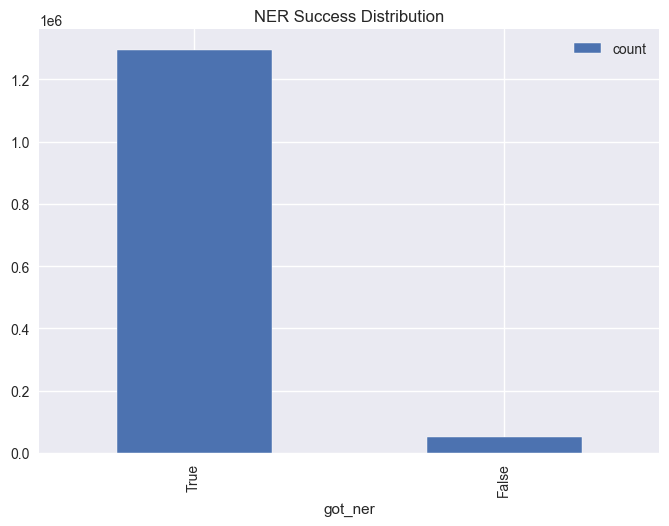

In [58]:
ner_counts = jobs_full_df.groupBy("got_ner").count().toPandas()

ner_counts.plot(kind="bar", x="got_ner", y="count", title="NER Success Distribution")
plt.show()


#### B. NER success by job_type (Remote, Hybrid, Onsite)

In [59]:
jobs_full_df.groupBy("job_type") \
    .agg(F.avg(F.col("got_ner").cast("float")).alias("ner_rate")) \
    .orderBy(F.desc("ner_rate")).show()


+--------+------------------+
|job_type|          ner_rate|
+--------+------------------+
|  Hybrid|0.9996951684194483|
|  Remote|0.9992956092979572|
|  Onsite|0.9610914520220617|
+--------+------------------+



Overall, the NER success rate is very strong (>96%), indicating high-quality text data suitable for NLP and ML analyses.

### 3. Top 20 Most Common Job Titles

In [60]:
top_titles = (
    jobs_full_df.groupBy("job_title_clean")
        .count()
        .orderBy(F.desc("count"))
        .limit(20)
)

top_titles.show(truncate=False)


+-------------------------------------------------+-----+
|job_title_clean                                  |count|
+-------------------------------------------------+-----+
|customer service representative                  |9541 |
|lead sales associate ft                          |7325 |
|assistant manager                                |6856 |
|shift manager                                    |5928 |
|store manager                                    |5806 |
|first year tax professional                      |5356 |
|lead sales associate pt                          |4924 |
|registered nurse                                 |4481 |
|senior accountant                                |3034 |
|hourly supervisor training                       |2955 |
|host                                             |2938 |
|travel allied health professional ct technologist|2933 |
|account executive                                |2655 |
|registered nurse rn                              |2349 |
|restaurant ma

#### 4. Word Frequency Analysis

In [61]:
words_df = (
    jobs_full_df
    .select(F.explode(F.split(F.col("job_title_clean"), " ")).alias("word"))
    .filter(F.length("word") > 2)
)

top_words = words_df.groupBy("word").count().orderBy(F.desc("count")).limit(30)
top_words.show(truncate=False)


+------------+------+
|word        |count |
+------------+------+
|manager     |269904|
|senior      |125191|
|nurse       |116791|
|engineer    |84597 |
|assistant   |76143 |
|registered  |66466 |
|supervisor  |65756 |
|sales       |58795 |
|health      |54091 |
|lead        |53687 |
|and         |46649 |
|associate   |44320 |
|service     |42179 |
|technologist|39430 |
|care        |37186 |
|travel      |36847 |
|specialist  |36470 |
|analyst     |36137 |
|physician   |35921 |
|project     |30160 |
+------------+------+
only showing top 20 rows


In [62]:
jobs_with_seniority = jobs_full_df.withColumn(
    "seniority",
    F.when(F.col("job_title_clean").rlike("senior|lead|principal|director"), "Senior")
     .when(F.col("job_title_clean").rlike("middle|mid"), "Mid")
     .when(F.col("job_title_clean").rlike("junior|associate|assistant"), "Junior")
     .otherwise("Unknown")
)

seniority_dist = (
    jobs_with_seniority.groupBy("seniority").count().orderBy(F.desc("count"))
)
seniority_dist.show(truncate=False)


+---------+-------+
|seniority|count  |
+---------+-------+
|Unknown  |1037724|
|Senior   |211133 |
|Junior   |94439  |
|Mid      |5045   |
+---------+-------+



In [63]:
title_len_df = jobs_full_df.withColumn(
    "title_length", F.size(F.split(F.col("job_title_clean"), " "))
)

title_len_df.select("title_length").describe().show()

title_len_df.groupBy("title_length").count().orderBy("title_length").show()

+-------+-----------------+
|summary|     title_length|
+-------+-----------------+
|  count|          1348341|
|   mean| 4.47452832777465|
| stddev|2.578173977221174|
|    min|                1|
|    max|               37|
+-------+-----------------+

+------------+------+
|title_length| count|
+------------+------+
|           1| 35288|
|           2|254656|
|           3|311517|
|           4|239910|
|           5|148766|
|           6|114075|
|           7| 83543|
|           8| 53335|
|           9| 38420|
|          10| 22662|
|          11| 18150|
|          12| 10145|
|          13|  7517|
|          14|  3956|
|          15|  2279|
|          16|  1388|
|          17|  1066|
|          18|   599|
|          19|   388|
|          20|   187|
+------------+------+
only showing top 20 rows


Extremely long titles (15+ words) are very rare and noisy, we may need to truncate or standardize tags for job titles 

#### 5. Job categorization

In [64]:
# Seniority patterns mapping 
seniority_map = {
    "leadership": r"(?i)\b(chief|cxo|cto|cfo|coo|ceo|cmo|cio|president|vice president|vp|svp|evp|md)\b",

    "director": r"(?i)\b(director|head|dean)\b",

    "senior": r"(?i)\b("
              r"senior|sr|lead|leader|principal|advanced|expert|specialist|manager\b|"
              r"iii\b|iv\b|3\b|4\b|"
              r"staff (engineer|nurse|scientist)"
              r"(?<!assistant )(?<!junior )(?<!jr )(?<!trainee )(?<!training )(?<!entry )manager\b|"
              r"store manager|branch manager|operations manager|project manager\b|"
              r")\b",

    "mid": r"(?i)\b("
           r"mid|middle|intermediate|associate\b|level[\s\-]?(2|ii)\b|l2\b"
           r")\b",

    "junior": r"(?i)\b("
              r"junior|jr|entry|apprentice|trainee|"
              r"substitute|teacher assistant|paraeducator|"
              r"early learning|early childhood|early careers|"
              r"level[\s\-]?(1|i)\b|l1\b"
              r")\b",

    "intern": r"(?i)\b(intern|internship|student|fellow)\b"
}



jobs_with_seniority_df = jobs_full_df.withColumn("seniority", F.lit("unspecified"))

for label in ["leadership", "director", "senior", "mid", "junior", "intern"]:
    pattern = seniority_map[label]
    jobs_with_seniority_df = jobs_with_seniority_df.withColumn(
        "seniority",
        F.when(F.col("job_title_clean").rlike(pattern), label).otherwise(F.col("seniority"))
    )



In [65]:
jobs_with_seniority_df.show(15, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------+-----------+-------+---------------+--------------------------+----------------------------------------------------------------------------------------+---------------------------------------------------------------------------+----------+--------+----------------------------+----------+--------------+--------------+------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [66]:
# Step 2 Base Role Extraction
role_map = {
    "software_engineer": r"(?i)\b(engineer|developer|software|devops|full stack|backend|frontend)\b",
    "data_roles": r"(?i)\b(data|ml|machine learning|ai|analytics|scientist|analyst)\b",
    "product_roles": r"(?i)\b(product|pm|product manager)\b",
    "design_roles": r"(?i)\b(designer|ux|ui|graphic)\b",
    "business_roles": r"(?i)\b(business|operations|strategy|consultant)\b",
    "marketing_roles": r"(?i)\b(marketing|seo|content|growth|brand)\b",
    "sales_roles": r"(?i)\b(sales|account executive|bd|business development)\b",
    "finance_roles": r"(?i)\b(finance|accounting|fp&a|tax)\b",
    "hr_roles": r"(?i)\b(hr|human resources|recruiter|talent)\b",
    "healthcare_roles": r"(?i)\b(nurse|medical|clinic|healthcare|rn|physician)\b",
    "customer_support": r"(?i)\b(support|customer|service)\b",
    "project_program": r"(?i)\b(project|program|scrum|pmo|agile)\b",
    "manager_roles": r"(?i)\b(manager|supervisor)\b",
    "retail_hospitality": r"(?i)\b(chef|cook|waiter|retail|store)\b"
}

jobs_base_role_df = jobs_with_seniority_df.withColumn("raw_role", F.lit("other"))

for label, pattern in role_map.items():
    jobs_base_role_df = jobs_base_role_df.withColumn(
        "raw_role",
        F.when(F.col("job_title_clean").rlike(pattern), label).otherwise(F.col("raw_role"))
    )


In [67]:
seniority_terms = r"(?i)\b(senior|sr|lead|principal|mid|middle|junior|jr|entry|intern|internship|trainee|director|head|chief|vp|vice president)\b"

jobs_clean_title_df = jobs_base_role_df.withColumn(
    "title_base",
    F.trim(F.regexp_replace(F.col("job_title_clean"), seniority_terms, ""))
)


In [68]:
jobs_normalized_df = jobs_clean_title_df.withColumn(
    "title_normalized",
    F.lower(F.regexp_replace("title_base", r"\s{2,}", " "))
)


In [71]:
tokenizer = Tokenizer(inputCol="title_normalized", outputCol="title_tokens")
jobs_tokenized_df = tokenizer.transform(jobs_normalized_df)


We first tokenize before TF-IDF

In [72]:
remover = StopWordsRemover(
    inputCol="title_tokens",
    outputCol="title_filtered"
)

jobs_filtered_df = remover.transform(jobs_tokenized_df)


removing meaningless stop words (and, or, the, of, to, in, for, with, a, an, etc.)

In [105]:
hashing_tf = HashingTF(
    inputCol="title_filtered",
    outputCol="title_tf",
    numFeatures=20000
)

jobs_tf_df = hashing_tf.transform(jobs_filtered_df)

idf = IDF(inputCol="title_tf", outputCol="title_tfidf")
idf_model = idf.fit(jobs_tf_df)
jobs_tfidf_df = idf_model.transform(jobs_tf_df)


In [106]:
jobs_tfidf_df.select("company", "job_title_clean", "seniority", "raw_role", "title_base", "title_normalized", "title_tokens", "title_filtered", "title_tf", "title_tfidf").show(5, truncate=False)

+--------------------------+---------------------------------+---------+----------------+---------------------------------+---------------------------------+----------------------------------------+------------------------------------+--------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------+
|company                   |job_title_clean                  |seniority|raw_role        |title_base                       |title_normalized                 |title_tokens                            |title_filtered                      |title_tf                                                |title_tfidf                                                                                                                   |
+--------------------------+---------------------------------+---------+----------------+---------------------------------+---------------------------------+---

K=5: WSSSE=202767925.4047096
K=10: WSSSE=201012559.0596123
K=15: WSSSE=200037272.1729979
K=20: WSSSE=197028496.7309987
K=25: WSSSE=197078739.7657153
K=30: WSSSE=195096849.9919751


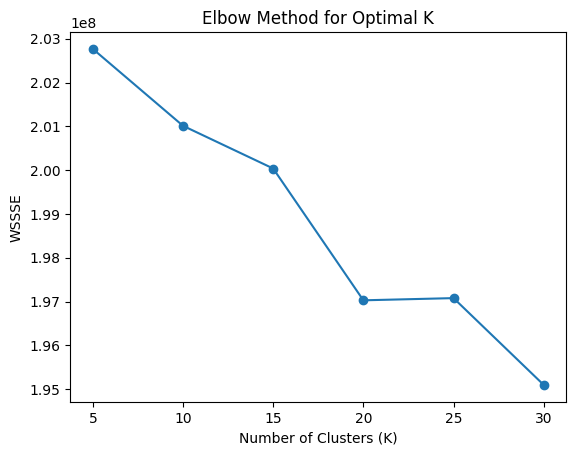

In [107]:
wssse_list = []
k_values = list(range(5, 31, 5))

for k in k_values:
    kmeans = KMeans(k=k, seed=42, featuresCol="title_tfidf")
    model = kmeans.fit(jobs_tfidf_df)
    wssse = model.summary.trainingCost
    wssse_list.append(wssse)
    print(f"K={k}: WSSSE={wssse}")

plt.plot(k_values, wssse_list, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WSSSE")
plt.show()


Choosing K number of Clusters, K = 20

In [108]:
kmeans = KMeans(
    featuresCol="title_tfidf",
    predictionCol="cluster",
    k=20,
    maxIter=30,
    seed=42
)

kmeans_model = kmeans.fit(jobs_tfidf_df)
jobs_clustered_final_df = kmeans_model.transform(jobs_tfidf_df)


In [109]:
jobs_clustered_final_df.select("company", "job_title_clean", "seniority", "raw_role", "title_base", "title_normalized", "title_tokens", "title_filtered", "title_tf", "title_tfidf", "cluster").show(15, truncate=False)

+--------------------------+---------------------------------------------------------------------------+---------+------------------+---------------------------------------------------------------------------+---------------------------------------------------------------------------+----------------------------------------------------------------------------------------+------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+
|company                   |job_title_clean                                                            |seniority|r

In [110]:
jobs_clustered_final_df.groupBy("cluster").count().orderBy("cluster").show()


+-------+-------+
|cluster|  count|
+-------+-------+
|      0|1028763|
|      1|    654|
|      2|   2482|
|      3|  26755|
|      4|  10741|
|      5|  27324|
|      6|  33381|
|      7|  22686|
|      8|  12798|
|      9|   4256|
|     10|  22476|
|     11|  95144|
|     12|   4542|
|     13|   3479|
|     14|  12537|
|     15|   3210|
|     16|   4052|
|     17|   9190|
|     18|   6732|
|     19|  17139|
+-------+-------+



In [111]:
for c in range(20):
    print(f"\n===== Cluster {c} =====")
    jobs_clustered_final_df.filter(F.col("cluster") == c) \
        .select("job_title_clean") \
        .show(20, truncate=False)



===== Cluster 0 =====
+-------------------------------------------------------------------+
|job_title_clean                                                    |
+-------------------------------------------------------------------+
|i e designer                                                       |
|client relations manager                                           |
|procurement lead                                                   |
|chronic care manager                                               |
|nurse manager assistant at hillside family of agencies             |
|systems engineer iii                                               |
|professor of practice and director of innovations in honors program|
|early learning academy substitute                                  |
|store manager                                                      |
|retail key holder                                                  |
|credentialed tax expert 2 yrs paid tax experience required        

In [125]:
cluster_tokens = (
    jobs_clustered_final_df
    .select("cluster", F.explode("title_filtered").alias("term"))
)

term_freq = (
    cluster_tokens
    .groupBy("cluster", "term")
    .count()
)

w = Window.partitionBy("cluster").orderBy(F.desc("count"))

# top 25 terms per  cluster
top_terms = (
    term_freq
    .withColumn("rank", F.row_number().over(w))
    .filter(F.col("rank") <= 25)
    .orderBy("cluster", F.desc("count"))
)


top_terms.show(800, truncate=False)


+-------+--------------+------+----+
|cluster|term          |count |rank|
+-------+--------------+------+----+
|0      |manager       |242679|1   |
|0      |engineer      |75916 |2   |
|0      |assistant     |66825 |3   |
|0      |supervisor    |58150 |4   |
|0      |sales         |55767 |5   |
|0      |associate     |41158 |6   |
|0      |analyst       |30898 |7   |
|0      |specialist    |30772 |8   |
|0      |project       |27512 |9   |
|0      |physician     |26907 |10  |
|0      |technician    |26803 |11  |
|0      |store         |25964 |12  |
|0      |account       |23347 |13  |
|0      |executive     |22226 |14  |
|0      |consultant    |21663 |15  |
|0      |shift         |21156 |16  |
|0      |service       |18686 |17  |
|0      |rn            |18291 |18  |
|0      |business      |17968 |19  |
|0      |operations    |17822 |20  |
|0      |volunteer     |17768 |21  |
|0      |health        |16920 |22  |
|0      |general       |15271 |23  |
|0      |advisor       |15245 |24  |
|

Cluster 1 - 19 seems meaningful but cluster 0 is too big - 1 million (garbage catch-all)

KMeans is distance-based: most points near the origin

Because TF-IDF on short texts produces many sparse vectors that are very identical at distance level.

That's why Tf-IDF numerical feature extraction technique + KMeans broke here (it works well for long texts),

Using Word2Vec which understands meaning is gonna be the use case here

In [74]:
jobs_filtered_df.select("title_filtered").show(5, truncate=False)

+------------------------------------+
|title_filtered                      |
+------------------------------------+
|[team, service, desk]               |
|[e, designer]                       |
|[client, relations, manager]        |
|[private, duty, nurse, lpn, aveanna]|
|[procurement]                       |
+------------------------------------+
only showing top 5 rows


In [75]:

max_len = jobs_filtered_df.select(
    F.max(F.size("title_filtered")).alias("max_length")
).collect()[0]["max_length"]

In [80]:
jobs_filtered_df.select("title_filtered").where(F.size("title_filtered") == 37).show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|title_filtered                                                                                                                                                                                        |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[washington, supervisor, general, merchandise, clover, park, tech, college, bookstore, ff, wa, d6, d6, ff, wa, d2, d2, ff, wa, d1, d1, ff, wa, d2, d1, ff, wa, d3, d3, ff, wa, d4, d2, ff, wa, d3, d2]|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [126]:
word2vec = Word2Vec(
    inputCol="title_filtered",
    outputCol="title_vec",
    vectorSize=100,
    minCount=5,
    windowSize=5,
    maxIter=20
)

w2v_model = word2vec.fit(jobs_filtered_df)
jobs_vec_df = w2v_model.transform(jobs_filtered_df)


In [127]:
# pickling the model word2vec for job_titles
model_path = r"C:\Users\saisw\Desktop\MPS_DS_assignments\Sem4\DIC\project_2\word2vec_model_jobtitle"
w2v_model.save(model_path)


In [81]:
job_title_word2vec_df_path = r"C:\Users\saisw\Desktop\MPS_DS_assignments\Sem4\DIC\project_2\vectorized_titles_df"
jobs_vec_df.write.mode("overwrite").parquet(job_title_word2vec_df_path)

NameError: name 'jobs_vec_df' is not defined

In [130]:
jobs_vec_df.cache()
jobs_vec_df.count()

1348341

In [82]:
jobs_vec_df = spark.read.parquet(job_title_word2vec_df_path)

In [83]:
jobs_vec_df.show(1)

+--------------------+--------------------+-----------+-------+---------------+--------------------+--------------------+--------------------+----------+--------+--------------------+----------+-----------+--------------+---------------------+--------------------+--------------------+--------+---------+--------------+---------+----------------+------------------+-----------------+--------------------+--------------------+--------------------+
|            job_link| last_processed_time|got_summary|got_ner|is_being_worked|             company|           job_title|     job_title_clean| job_level|job_type|        job_location|first_seen|search_city|search_country|search_position_clean|   job_summary_clean|        skills_array|job_city|job_state|summary_length|seniority|        raw_role|        title_base| title_normalized|        title_tokens|      title_filtered|           title_vec|
+--------------------+--------------------+-----------+-------+---------------+--------------------+------

In [131]:


evaluator = ClusteringEvaluator(
    featuresCol="title_vec",
    predictionCol="cluster",
    metricName="silhouette",
    distanceMeasure="cosine"
)

k_values = [20, 25, 30, 35, 40, 45]
results = []

for k in k_values:
    print(f"Training BisectingKMeans with k={k}...")
    bkm = BisectingKMeans(
        featuresCol="title_vec",
        predictionCol="cluster",
        k=k,
        maxIter=30,
        seed=42
    )
    model = bkm.fit(jobs_vec_df)
    preds = model.transform(jobs_vec_df)

    silhouette = evaluator.evaluate(preds)
    results.append((k, silhouette))
    print(f"k={k}, silhouette={silhouette}")


Training BisectingKMeans with k=20...
k=20, silhouette=0.07750995791633132
Training BisectingKMeans with k=25...
k=25, silhouette=0.05543870785874032
Training BisectingKMeans with k=30...
k=30, silhouette=0.05934881282462988
Training BisectingKMeans with k=35...
k=35, silhouette=0.06863089291511086
Training BisectingKMeans with k=40...
k=40, silhouette=0.06296690911708881
Training BisectingKMeans with k=45...
k=45, silhouette=0.05142864095845118


silhouette score is highest for k = 20 but as we saw previously cluster 0 size is too broad

k = 35 gives the best trade-off

In [132]:
best_k = 35

bkm = BisectingKMeans(
    featuresCol="title_vec",
    predictionCol="cluster",
    k=best_k,
    maxIter=30,
    seed=42
)

best_model = bkm.fit(jobs_vec_df)
jobs_clustered_best_df = best_model.transform(jobs_vec_df)


In [133]:
jobs_clustered_best_df.groupBy("cluster").count().orderBy("cluster").show(50, truncate=False)


+-------+------+
|cluster|count |
+-------+------+
|0      |77108 |
|1      |31912 |
|2      |27818 |
|3      |86646 |
|4      |5479  |
|5      |2658  |
|6      |11632 |
|7      |4034  |
|8      |54584 |
|9      |20288 |
|10     |6466  |
|11     |9891  |
|12     |23979 |
|13     |9642  |
|14     |6945  |
|15     |6099  |
|16     |168269|
|17     |57003 |
|18     |53193 |
|19     |87918 |
|20     |23989 |
|21     |11304 |
|22     |144753|
|23     |10627 |
|24     |14428 |
|25     |57551 |
|26     |31726 |
|27     |28389 |
|28     |12690 |
|29     |65019 |
|30     |44174 |
|31     |91007 |
|32     |5888  |
|33     |43159 |
|34     |12073 |
+-------+------+



In [135]:
# Extract top terms per cluster
exploded = jobs_clustered_best_df.select(
    "cluster",
    F.explode("title_filtered").alias("term")
)

cluster_terms = (exploded
    .groupBy("cluster", "term")
    .count()
    .withColumn("rank", F.row_number().over(
        Window.partitionBy("cluster").orderBy(F.desc("count"))
    ))
)

cluster_terms.filter("rank <= 25").orderBy("cluster", "rank").show(1500, truncate=False)

+-------+---------------+-----+----+
|cluster|term           |count|rank|
+-------+---------------+-----+----+
|0      |nurse          |62336|1   |
|0      |registered     |48656|2   |
|0      |rn             |42760|3   |
|0      |health         |11493|4   |
|0      |care           |9128 |5   |
|0      |healthcare     |5705 |6   |
|0      |manager        |4989 |7   |
|0      |icu            |4705 |8   |
|0      |unit           |3921 |9   |
|0      |home           |3488 |10  |
|0      |medical        |3397 |11  |
|0      |lpn            |3063 |12  |
|0      |nights         |2962 |13  |
|0      |case           |2881 |14  |
|0      |dialysis       |2598 |15  |
|0      |room           |2466 |16  |
|0      |emergency      |2393 |17  |
|0      |duty           |2257 |18  |
|0      |clinical       |2201 |19  |
|0      |days           |2199 |20  |
|0      |private        |2162 |21  |
|0      |oncology       |2137 |22  |
|0      |prn            |2127 |23  |
|0      |staff          |2121 |24  |
|

In [137]:
cluster_labels = {
    0:  "General Nursing (RN/LPN/ICU/Clinical)",
    1:  "Travel Nurses (Med-Surg / ICU / Telemetry)",
    2:  "Therapy & Allied Health (PT/OT/Respiratory)",
    3:  "Nurse Managers & Clinical Supervisors",
    4:  "Mental Health Counselors (LCSW/LPC/LMFT)",
    5:  "Marriage & Family Therapists (LMFT)",
    6:  "Behavioral Health & Social Workers",
    7:  "Rehab & Speech Therapy (SLP/OT/PT Assistants)",
    8:  "Physicians (General & Specialist MD/DO)",
    9:  "Physicians (Locum/Contract/High Compensation)",
    10: "Dentists & Dental Specialists",
    11: "Veterinarians & Animal Doctors",
    12: "Medical Technologists & Lab Techs",
    13: "Allied Health Imaging & Diagnostics",
    14: "Radiologic & X-Ray Imaging Specialists",
    15: "Advanced Imaging (CT/MRI/Ultrasound/PET)",
    16: "Operations / Admin / Service Management",
    17: "Education, Teaching, Coaching & Training",
    18: "Retail & Restaurant Store Management",
    19: "Manufacturing Shift Leaders & Supervisors",
    20: "Culinary (Chefs, Cooks, Kitchen Staff)",
    21: "Hospitality (Hosts, Attendants, Front-of-House)",
    22: "Business, Finance & Account Management",
    23: "Tax & Accounting Professionals",
    24: "Attorneys & Legal Services",
    25: "Sales Reps (Inside/Outside/Territory)",
    26: "Customer Service & Call Center",
    27: "Technicians & Skilled Trades",
    28: "Construction Site Leadership (Superintendent/Foreman)",
    29: "Industrial & Construction Project Management",
    30: "Core Engineering (Mechanical/Electrical/Civil)",
    31: "Security Clearance / Analysts / Technology Ops",
    32: "Accounting Specialists (Cost/Inventory/Audit)",
    33: "Software Engineering / Cloud / DevOps / Network",
    34: "Software Developers (Full Stack / Backend / Java/Python)"
}


expr = F.create_map([F.lit(x) for kv in cluster_labels.items() for x in kv])

jobs_labeled_df = jobs_clustered_best_df.withColumn("job_category", expr[F.col("cluster")])

In [138]:
jobs_labeled_df.select(
    "cluster",
    "job_category",
    "job_title_clean"
).show(50, truncate=False)


+-------+-----------------------------------------------+---------------------------------------------------------------------------+
|cluster|job_category                                   |job_title_clean                                                            |
+-------+-----------------------------------------------+---------------------------------------------------------------------------+
|19     |Manufacturing Shift Leaders & Supervisors      |team lead service desk                                                     |
|30     |Core Engineering (Mechanical/Electrical/Civil) |i e designer                                                               |
|22     |Business, Finance & Account Management         |client relations manager                                                   |
|0      |General Nursing (RN/LPN/ICU/Clinical)          |private duty nurse lpn at aveanna                                          |
|31     |Security Clearance / Analysts / Technology Ops |procu

Preview of the clustering labels is reasonably accurate and believable with the help of word2vec semantic embeddings extracted from job titles

By replacing TF-IDF with word2vec, the semantic structure of job titles was captured more accurately. Word2Vec learned the meaning and relationships between job related terms, enabling Bisecting KMeans to form clean, meaningful job clusters. The resulting 35 clusters aligned closely with real-world job families such as nursing, physicians, therapists, retail management, engineering, software development, sales, customer service, legal, tax, accounting, and construction. These clusters were then labeled using the top representative terms from each cluster, allowing the creation of a robust, accurate, and human-readable job taxonomy for 1.3M LinkedIn postings. Word2Vec provided dense semantic embeddings that made clustering significantly more accurate and interpretable compared to TF-IDF, which failed due to sparse vectors.

In [139]:
# saving this cluster labelled data

job_category_cluster_label_path = r"C:\Users\saisw\Desktop\MPS_DS_assignments\Sem4\DIC\project_2\cluster_label"
jobs_labeled_df.write.mode("overwrite").parquet(job_category_cluster_label_path)

In [84]:
job_category_cluster_label_path = r"C:\Users\saisw\Desktop\MPS_DS_assignments\Sem4\DIC\project_2\cluster_label"
jobs_labeled_df = spark.read.parquet(job_category_cluster_label_path)

In [85]:
jobs_labeled_df.show(3, truncate=False)

+------------------------------------------------------------------------------------------------+--------------------------+-----------+-------+---------------+--------------------------+------------------------+------------------------+----------+--------+----------------------------+----------+-----------+--------------+------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

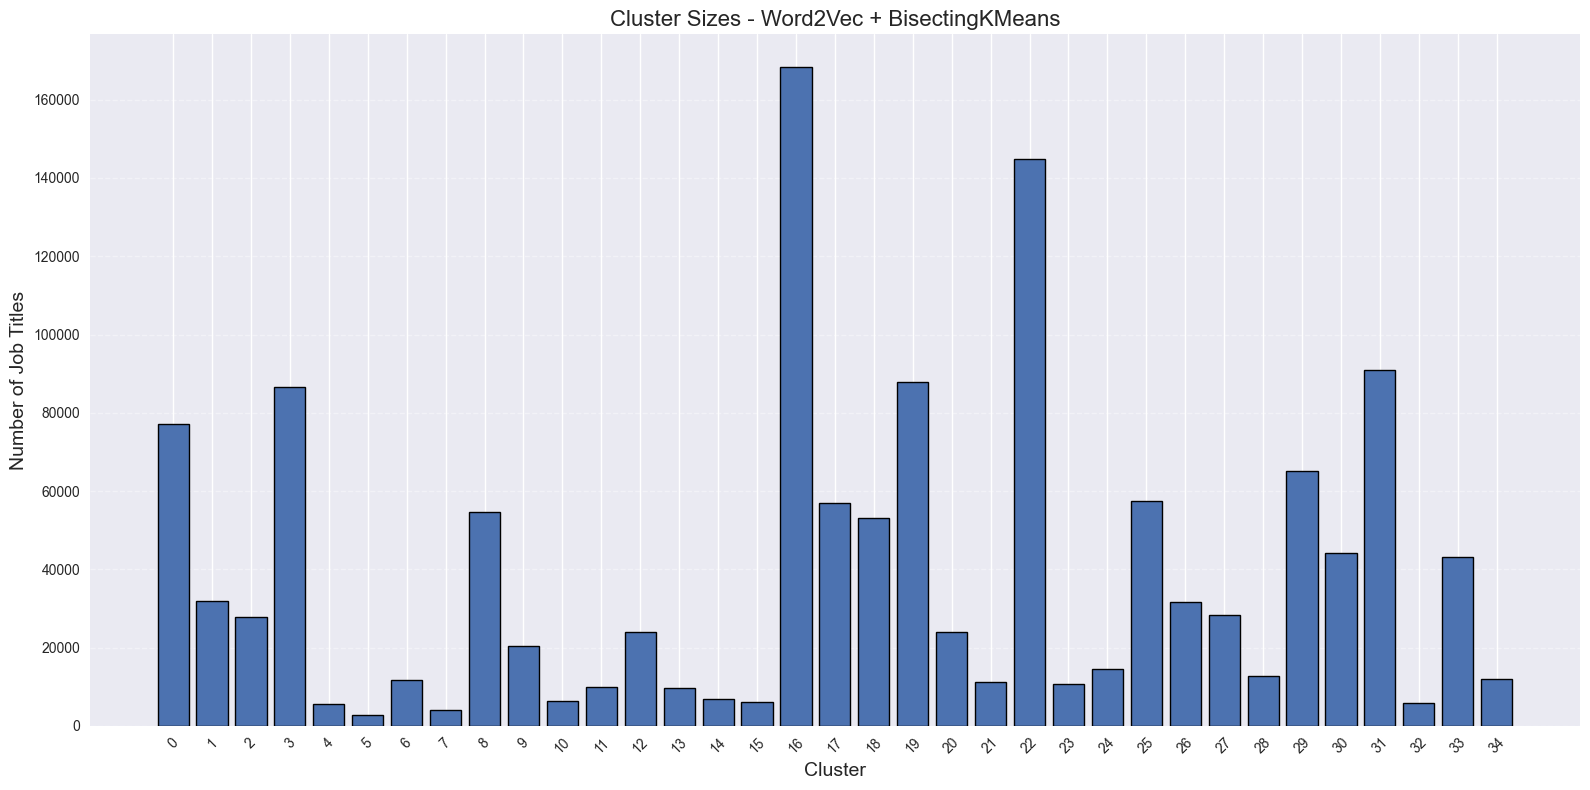

In [87]:
plt.style.use('seaborn-v0_8-deep')

cluster_counts_df = (
    jobs_labeled_df
        .groupBy("cluster")
        .count()
        .orderBy("cluster")
)

cluster_counts_pd = cluster_counts_df.toPandas()

plt.figure(figsize=(16, 8))
plt.bar(
    cluster_counts_pd['cluster'],
    cluster_counts_pd['count'],
    linewidth=1,
    edgecolor="black"
)

plt.xlabel("Cluster", fontsize=14)
plt.ylabel("Number of Job Titles", fontsize=14)
plt.title("Cluster Sizes - Word2Vec + BisectingKMeans", fontsize=16)
plt.xticks(cluster_counts_pd['cluster'], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


To understand the structure of more than 1.3 million job titles, we needed a way to automatically group similar job roles together, even when they differ in wording.

Some clusters are large compared to others like cluster 16: Operations / Admin / Service Management that means these job titles are abundant in job market and if you are able to acquire the required skills then there would be less trouble landing yourself a job in this domain. Business and finance roles also seem abundant.

To categorize these job titles I used word2vec to get embeddings for the job titles in a array and using BisectingKMeans with good k value (35) for a good tuning parameter (silouhette = 0.68) we got a good distribution of job titles across each cluster (which was not the case in TF-IDF embeddings along with KMeans).

Some clusters are fairly small (cluster 5, 7, 13, 14, 15): Marriage & Family Therapists, Rehab & Speech Therapy, Allied Health Imaging, Advanced Imaging, Dentists

These job categories are niche and have fewer postings, so they naturally form smaller clusters.

After clustering, we manually inspected high-frequency keywords in each cluster and assigned human-readable names



In [34]:
pca = PCA(k=2, inputCol="title_vec", outputCol="pca_vec")
pca_model = pca.fit(jobs_labeled_df)
pca_df = pca_model.transform(jobs_labeled_df)

pca_df = pca_df.withColumn("pca_arr", vector_to_array("pca_vec"))

pca_sample = (
    pca_df
        .select(
            "cluster",
            F.col("pca_arr")[0].alias("pc1"),
            F.col("pca_arr")[1].alias("pc2")
        )
        .sample(False, 0.03)
)

pca_pd = pca_sample.toPandas()

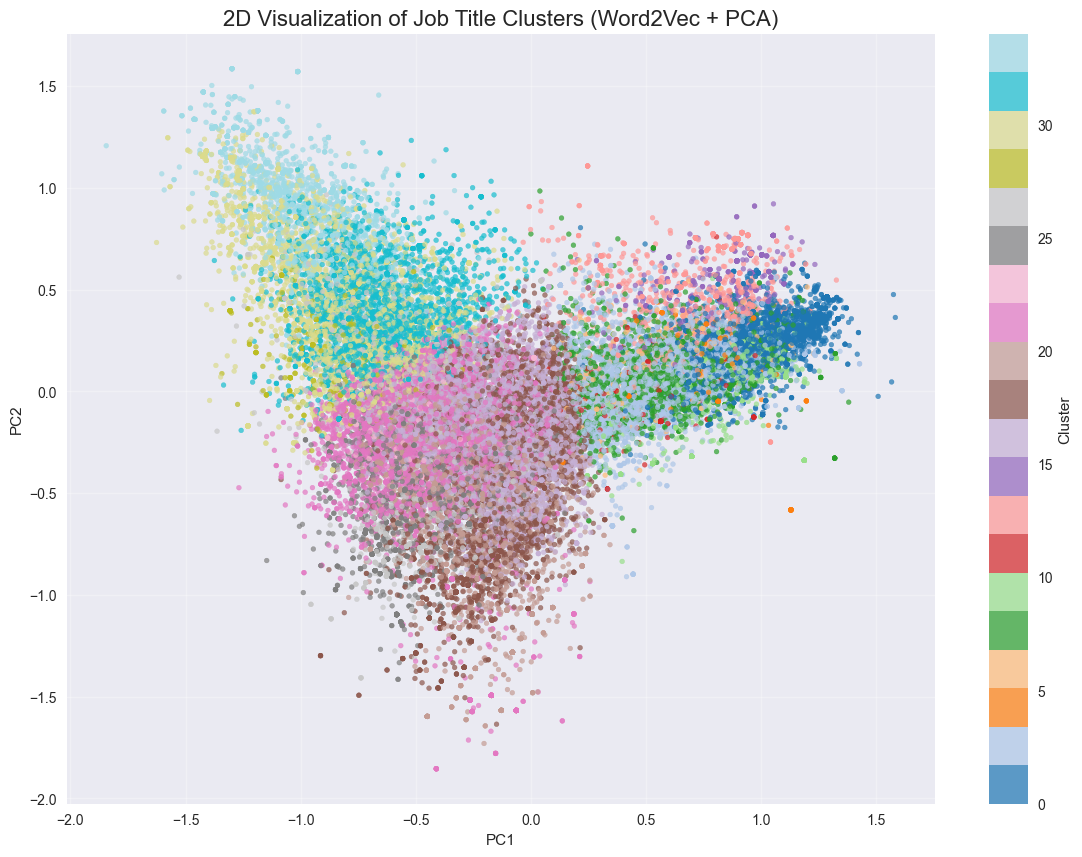

In [35]:
plt.figure(figsize=(14, 10))
plt.scatter(
    pca_pd["pc1"],
    pca_pd["pc2"],
    c=pca_pd["cluster"],
    cmap="tab20",
    alpha=0.7,
    s=12
)

plt.title("2D Visualization of Job Title Clusters (Word2Vec + PCA)", fontsize=16)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.grid(alpha=0.3)
plt.show()


Above I reduced the 100 features word2vec array to 2 features (principal components) to make it possible for us to vissualize these 35 job title clusters on a 2D grid. We can see here how each of the job titles are spread across these 2 PCs. We have all 35 clusters that's why it looks cluttered but there is clear distinction between these groups formation. 

In [88]:
jobs_labeled_df.show(1, truncate=False)

+------------------------------------------------------------------------------------------------+--------------------------+-----------+-------+---------------+--------------------------+------------------------+----------------------+----------+--------+----------------------------+----------+-----------+--------------+---------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

C:\Users\saisw\AppData\Local\Temp\ipykernel_32752\3307373861.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


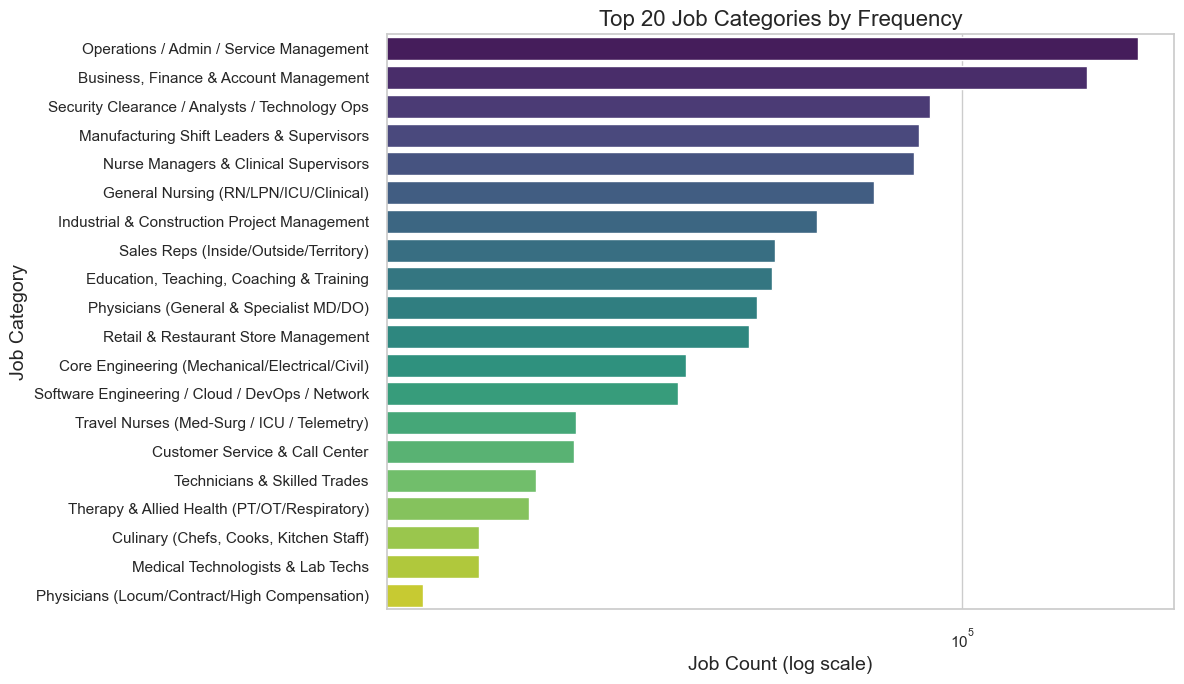

In [89]:
cat_counts_df = (
    jobs_labeled_df
        .groupBy("job_category")
        .count()
        .orderBy(F.desc("count"))
)

cat_counts_pd = cat_counts_df.limit(20).toPandas()

plt.figure(figsize=(12, 7))
sns.set(style="whitegrid")

sns.barplot(
    data=cat_counts_pd,
    x="count",
    y="job_category",
    palette="viridis"
)

plt.xscale("log")
plt.xlabel("Job Count (log scale)", fontsize=14)
plt.ylabel("Job Category", fontsize=14)
plt.title("Top 20 Job Categories by Frequency", fontsize=16)

plt.tight_layout()
plt.show()


Distribution of Top 20 most occuring Job categories frequency in the 2024 job market. There were a lot of openings in Operations/admin sector, Business, Finance jobs and also a lot of healthcare sector jobs were trending

In [11]:
selected_categories = [
    "Software Developers (Full Stack / Backend / Java/Python)",
    "Core Engineering (Mechanical/Electrical/Civil)",
    "Education, Teaching, Coaching & Training",
    "Physicians (General & Specialist MD/DO)",
    "Radiologic & X-Ray Imaging Specialists",
    "Tax & Accounting Professionals",
    "Sales Reps (Inside/Outside/Territory)",
    "Travel Nurses (Med-Surg / ICU / Telemetry)",
    "Dentists & Dental Specialists",
    "Culinary (Chefs, Cooks, Kitchen Staff)",
    "Manufacturing Shift Leaders & Supervisors"
]

jobs_filtered = jobs_labeled_df.filter(
    F.col("job_category").isin(selected_categories)
)

skill_counts = (
    jobs_filtered
    .groupBy("job_category")
    .agg(F.flatten(F.collect_list("skills_array")).alias("skills_flat"))
)

exploded = skill_counts.select(
    "job_category",
    F.explode("skills_flat").alias("skill")
)

skill_freq = exploded.groupBy("job_category", "skill").count()

w_total = Window.partitionBy("job_category")

skill_freq = (
    skill_freq
    .withColumn("total_in_cat", F.sum("count").over(w_total))
    .withColumn("pct", F.col("count") / F.col("total_in_cat"))
)

# top 5 skills per category
TOP_N = 5
w_rank = Window.partitionBy("job_category").orderBy(F.desc("pct"))

top_skills = (
    skill_freq
    .withColumn("rank", F.row_number().over(w_rank))
    .filter(F.col("rank") <= TOP_N)
    .select("job_category", "skill", "pct")
)


C:\Users\saisw\AppData\Roaming\Python\Python310\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\saisw\AppData\Roaming\Python\Python310\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\saisw\AppData\Roaming\Python\Python310\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\saisw\AppData\Roaming\Python\Python310\site-packages\seaborn\axisgrid.py:854: F

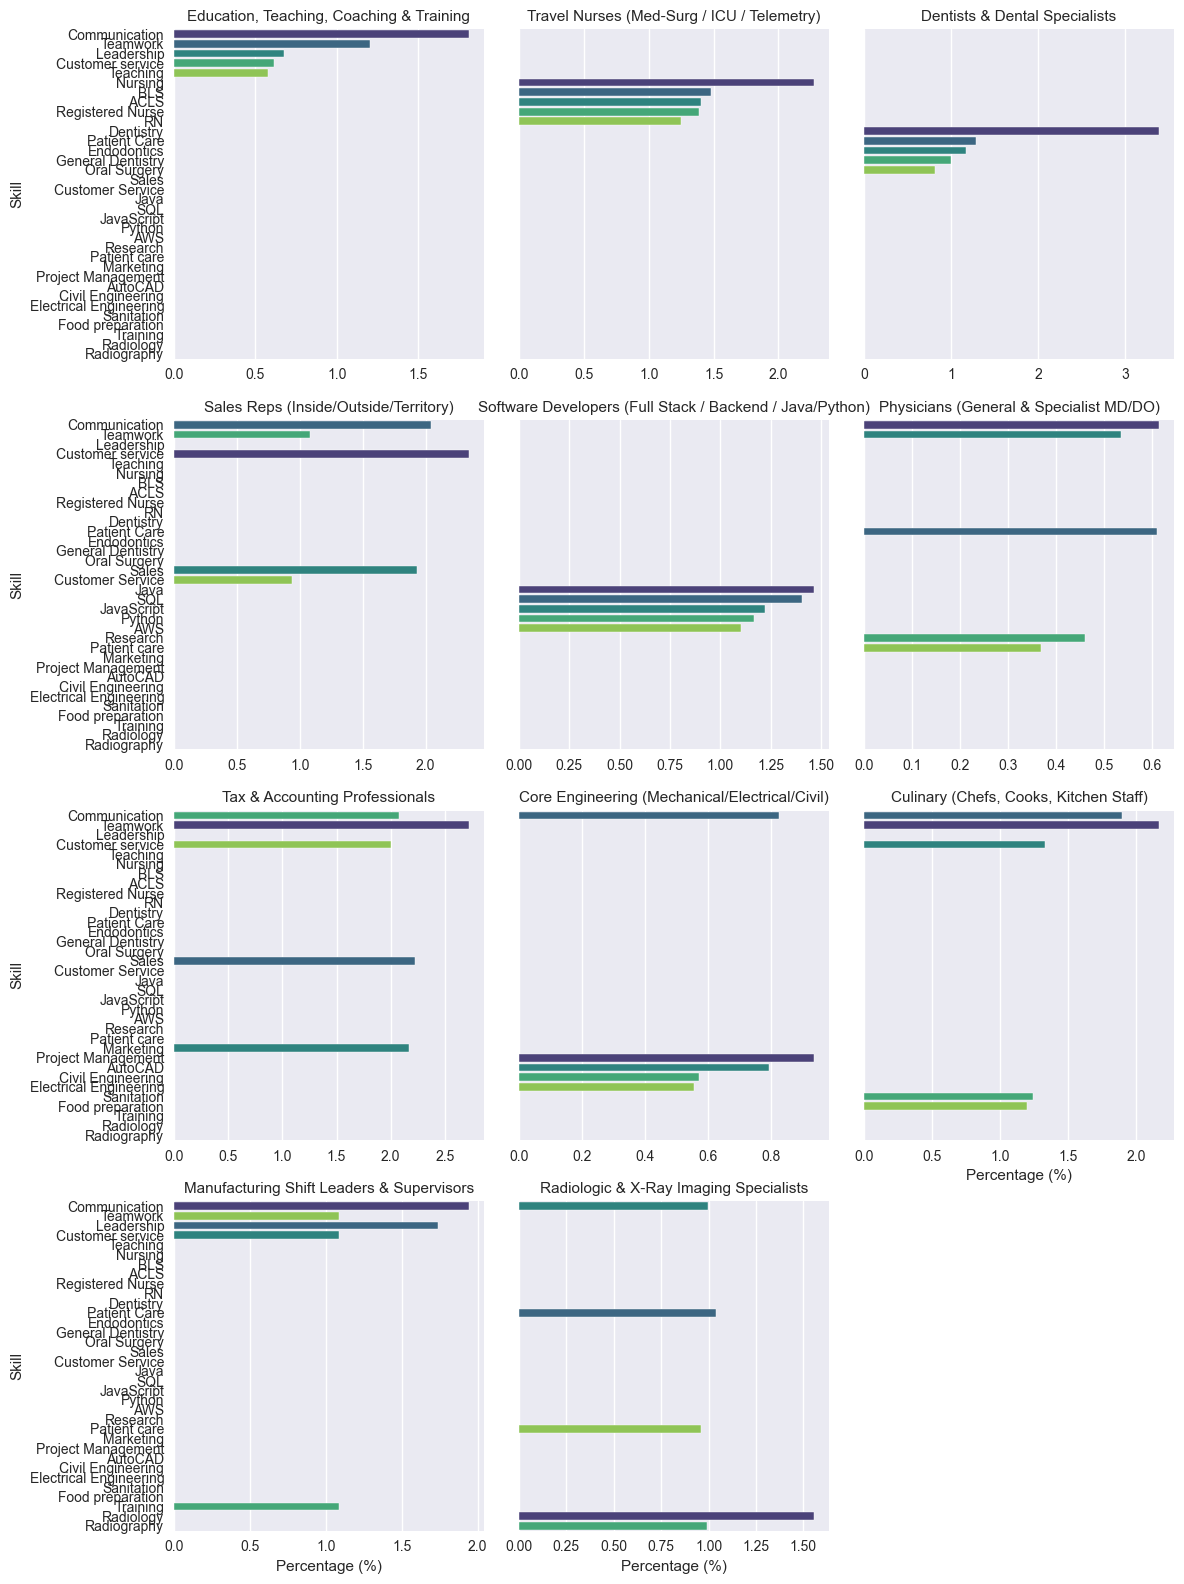

In [12]:
top_skills_pd = top_skills.toPandas()
plt.style.use("seaborn-v0_8")

top_skills_pd["pct_display"] = top_skills_pd["pct"] * 100

g = sns.FacetGrid(
    top_skills_pd,
    col="job_category",
    col_wrap=3,
    height=4,
    sharex=False
)

g.map_dataframe(
    sns.barplot,
    x="pct_display",
    y="skill",
    palette="viridis"
)

g.set_axis_labels("Percentage (%)", "Skill")
g.set_titles(col_template="{col_name}")
plt.tight_layout()
plt.show()


Above you can see a graph of percentage of top 5 skills per selected job categories. The top 5 skills for each job category is pretty much relevent to the job field and is reasonaly accurate across each group.

In [11]:
TOP_K = 5


skill_counts = (
    jobs_labeled_df
    .groupBy("job_category")
    .agg(F.flatten(F.collect_list("skills_array")).alias("skills_flat"))
)

cat_exploded = (
    skill_counts
    .select("job_category", F.explode("skills_flat").alias("skill"))
)

# skill freq per category
skill_freq = (
    cat_exploded
    .groupBy("job_category", "skill")
    .count()
)

cat_totals = (
    skill_freq
    .groupBy("job_category")
    .agg(F.sum("count").alias("total_count"))
)

skill_pct = (
    skill_freq
    .join(cat_totals, "job_category")
    .withColumn("pct", F.col("count") / F.col("total_count") * 100)
)

top_k_df = (
    skill_pct
    .groupBy("job_category")
    .agg(
        F.slice(
            F.array_sort(
                F.collect_list(F.struct(F.col("pct"), F.col("skill")))
            ), 
            -TOP_K, TOP_K
        ).alias("top_skills")
    )
)


In [12]:
top_k_final = (
    top_k_df
    .select(
        "job_category",
        F.explode("top_skills").alias("skill_struct")
    )
    .select(
        "job_category",
        F.col("skill_struct.skill").alias("skill"),
        F.col("skill_struct.pct").alias("pct")
    )
)


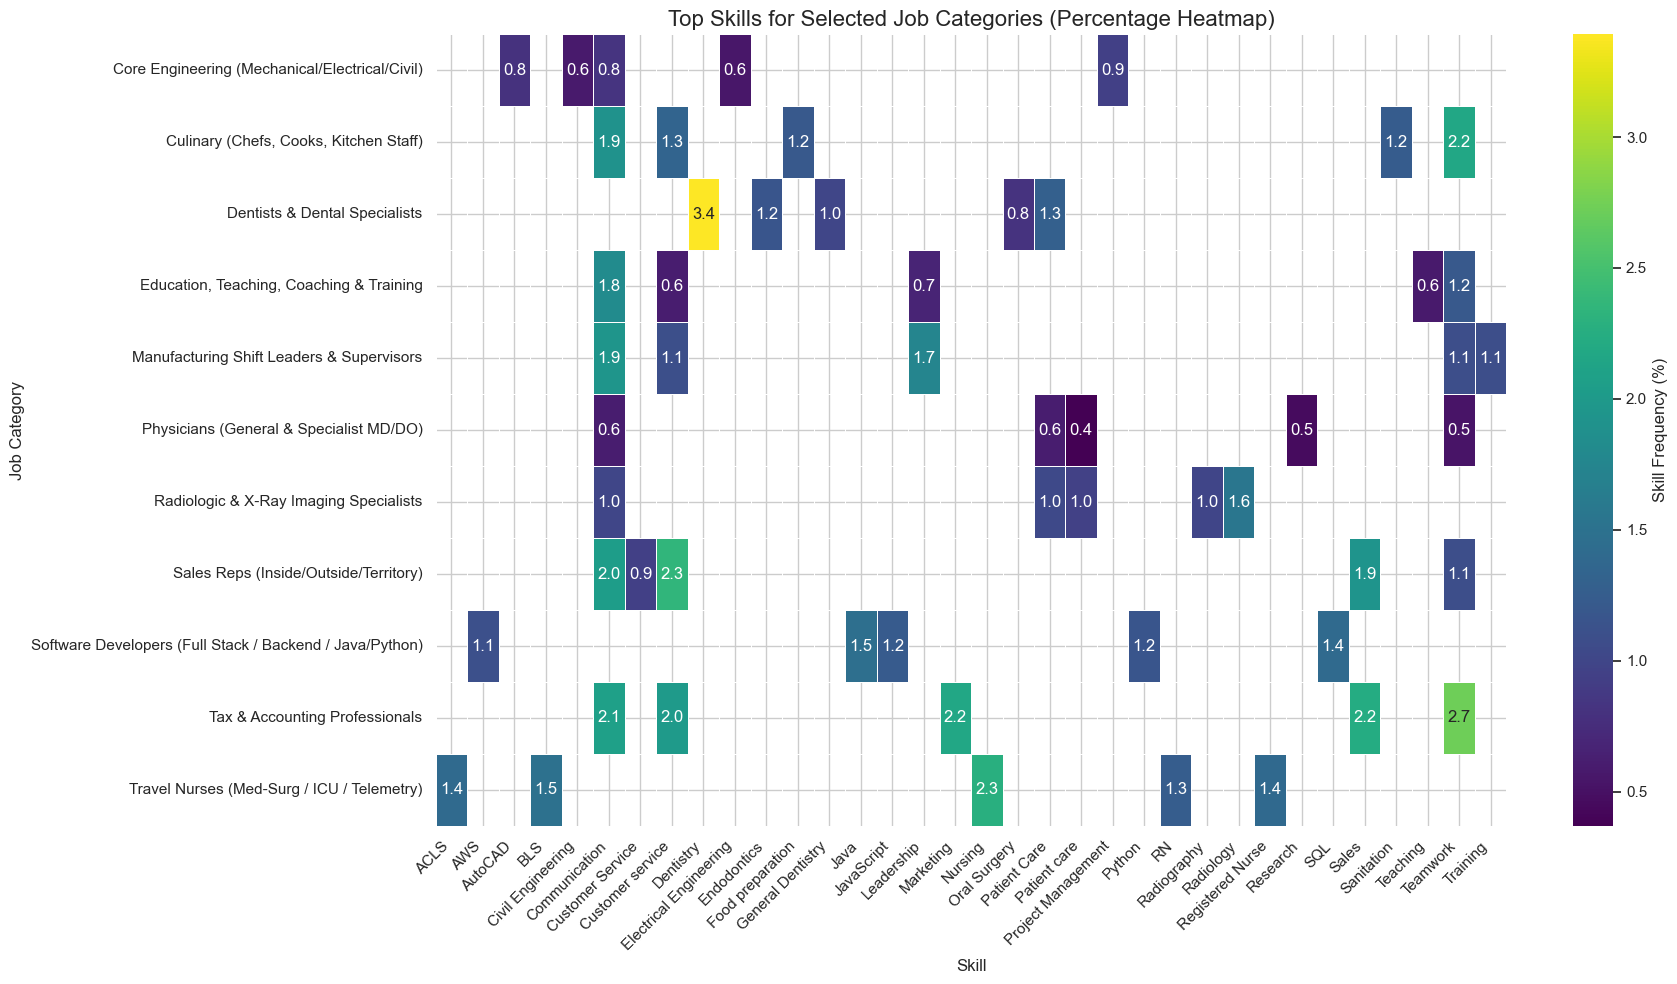

In [13]:
top_k_pandas = top_k_final.toPandas()

selected_categories = [
    "Software Developers (Full Stack / Backend / Java/Python)",
    "Core Engineering (Mechanical/Electrical/Civil)",
    "Education, Teaching, Coaching & Training",
    "Physicians (General & Specialist MD/DO)",
    "Radiologic & X-Ray Imaging Specialists",
    "Tax & Accounting Professionals",
    "Sales Reps (Inside/Outside/Territory)",
    "Travel Nurses (Med-Surg / ICU / Telemetry)",
    "Dentists & Dental Specialists",
    "Culinary (Chefs, Cooks, Kitchen Staff)",
    "Manufacturing Shift Leaders & Supervisors"
]

filtered_topk = top_k_pandas[
    top_k_pandas["job_category"].isin(selected_categories)
]


heatmap_df = filtered_topk.pivot(
    index="job_category",
    columns="skill",
    values="pct"
)

plt.figure(figsize=(18, 10))
sns.heatmap(
    heatmap_df,
    annot=True,
    fmt=".1f",
    cmap="viridis",
    linewidths=.5,
    cbar_kws={"label": "Skill Frequency (%)"}
)

plt.title("Top Skills for Selected Job Categories (Percentage Heatmap)", fontsize=16)
plt.xlabel("Skill")
plt.ylabel("Job Category")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Similar to what we saw in the above graph, here in the heat map also we ar eseeing top 5 most relevant skills across the selected job categories. Let's take a close look at Software Dev role, the top 5 skills based on their occurance are AWS, Java, Javascript, Python, SQL which is evidently a key requirement for Full stack/backend development and similarly we can take a look at the other job roles as well

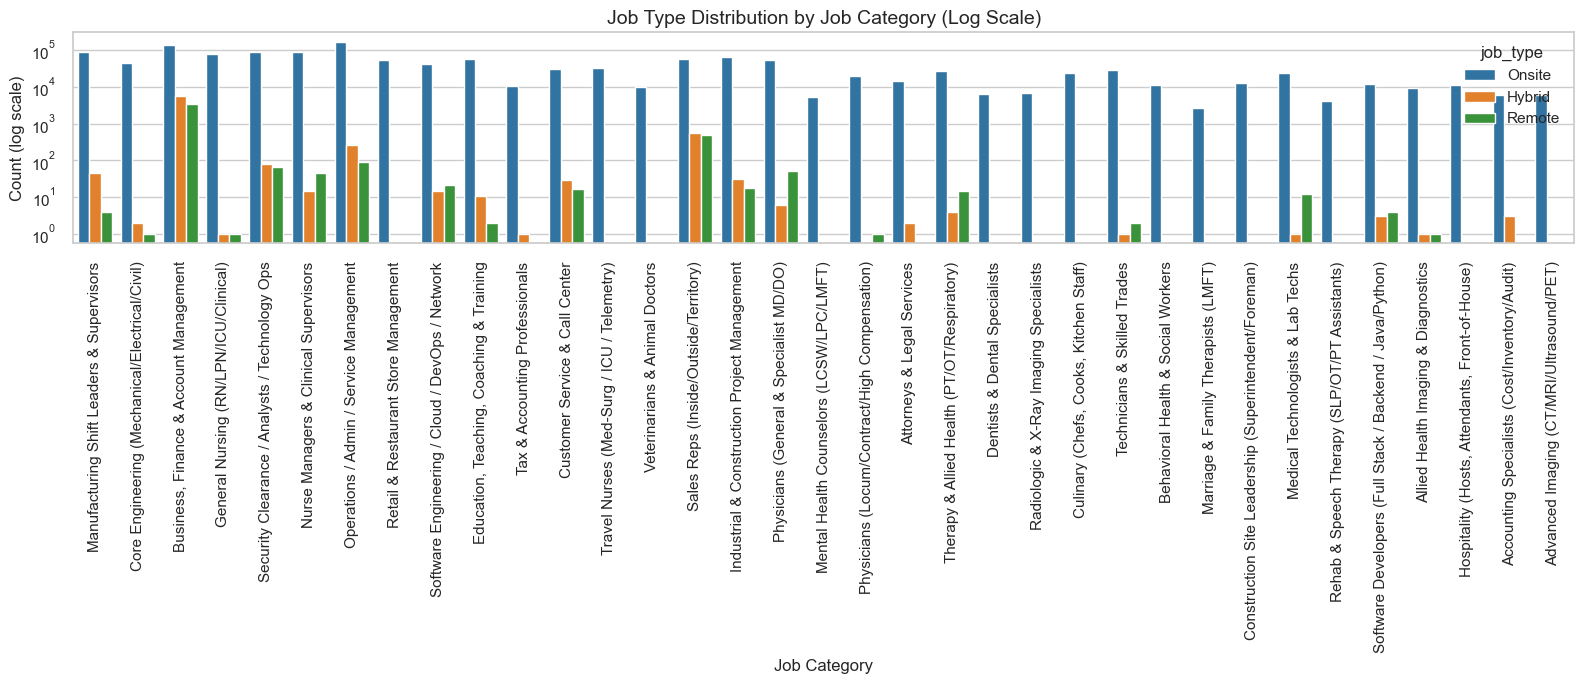

In [90]:
pdf = jobs_labeled_df.select("job_category", "job_type").toPandas()

pdf["job_type"] = pdf["job_type"].fillna("Unknown")

plt.figure(figsize=(16, 7))

sns.countplot(
    data=pdf,
    x="job_category",
    hue="job_type",
    palette="tab10"
)

plt.yscale("log")
plt.xticks(rotation=90)
plt.title("Job Type Distribution by Job Category (Log Scale)", fontsize=14)
plt.xlabel("Job Category")
plt.ylabel("Count (log scale)")
plt.tight_layout()
plt.show()


Graph of Job types (Onsite, Hybrid, Remote) jobs distribution across Job Categories:

We can see the log frequency distribution of jobs that are onsite/remote/hybrid for each job category.

Some jobs that can't be done remotely, for example: mostly healthcare (like dentists, radiologists, nursing, animal doctors) have to work onsite to serve the community, as well as Construction site Leadership roles that is clearly executed on the field.

Business/Finance/Accounting Management seem to have a balanced blend and most openings for Hybrid and Remote jobs.

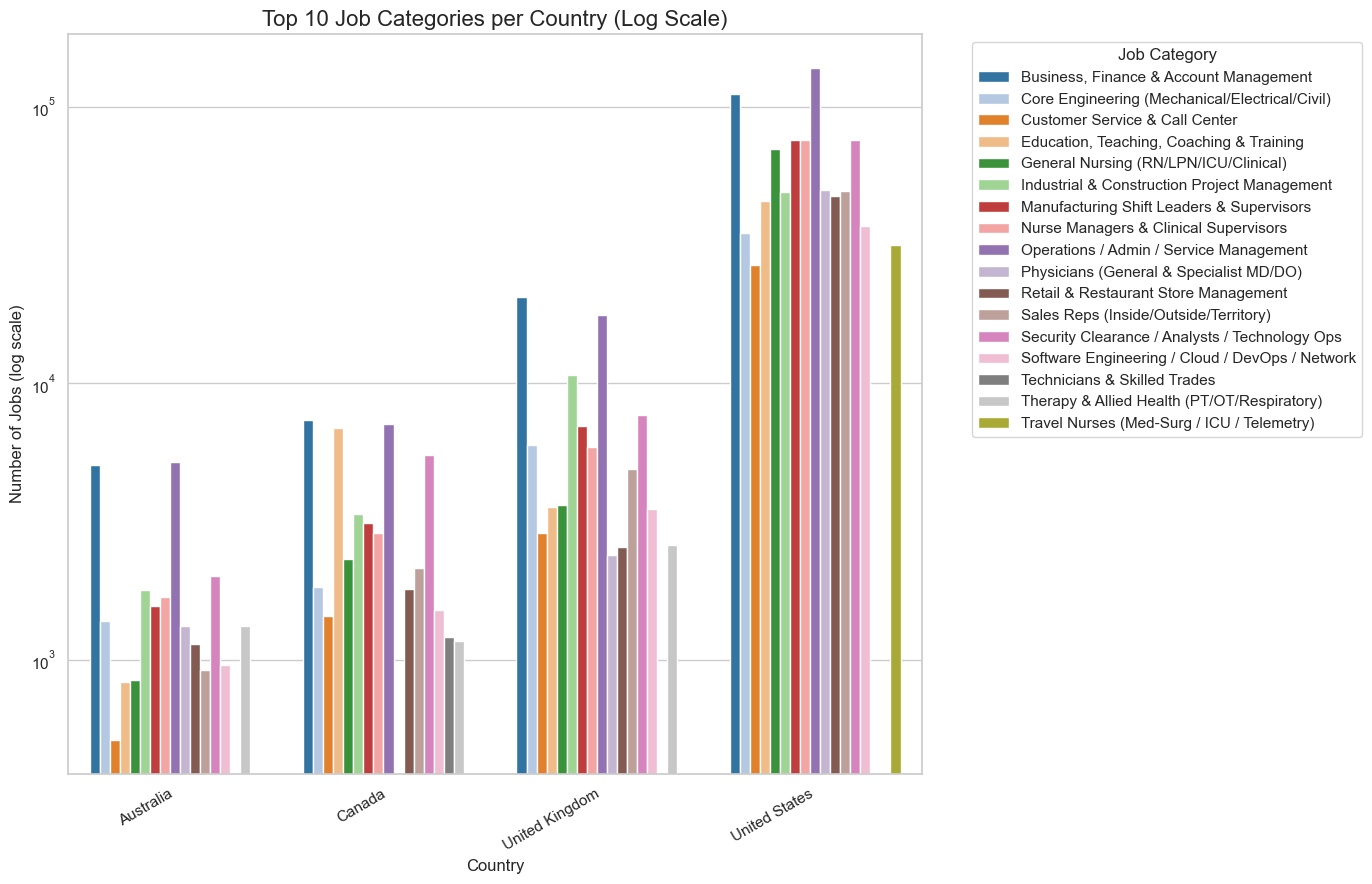

In [18]:
cat_counts = (
    jobs_labeled_df
        .groupBy("search_country", "job_category")
        .count()
)

# Pick TOP 15 categories per country

w = Window.partitionBy("search_country").orderBy(F.desc("count"))

top15 = (
    cat_counts
        .withColumn("rank", F.row_number().over(w))
        .filter(F.col("rank") <= 15)
        .drop("rank")
)


pdf = top15.toPandas()

pdf["job_category"] = pdf["job_category"].astype("category")


plt.figure(figsize=(14, 9))
sns.set(style="whitegrid")

sns.barplot(
    data=pdf,
    x="search_country",
    y="count",
    hue="job_category",
    palette="tab20"
)

plt.yscale("log")
plt.xlabel("Country", fontsize=12)
plt.ylabel("Number of Jobs (log scale)", fontsize=12)
plt.title("Top 15 Job Categories per Country", fontsize=16)

plt.xticks(rotation=30, ha='right')
plt.legend(title="Job Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


United States of America dominates in the number of job openings across all job categories as compared to the other countries in our data

In [14]:
skills_cleaned = (
    jobs_labeled_df
        .withColumn("skills", F.array_distinct("skills_array"))
        .withColumn("skills", F.array_sort("skills"))
)

pairs_df = (
    skills_cleaned
        .withColumn("skill_exploded", F.explode("skills"))
        .withColumn("pair", 
            F.expr("""
                filter(
                    transform(
                        skills,
                        s -> if(s > skill_exploded, concat(skill_exploded, ' + ', s), null)
                    ),
                    x -> x is not null
                )
            """)
        )
        .withColumn("pair", F.explode("pair"))
        .select("raw_role", "pair")
)


pair_counts = pairs_df.groupBy("raw_role", "pair").count()

w = Window.partitionBy("raw_role").orderBy(F.desc("count"))

top10_pairs = (
    pair_counts
        .withColumn("rank", F.row_number().over(w))
        .filter("rank <= 10")
        .orderBy("raw_role", F.desc("count"))
)

top10_pairs.show(200, truncate=False)

+------------------+--------------------------------------------------+-----+----+
|raw_role          |pair                                              |count|rank|
+------------------+--------------------------------------------------+-----+----+
|business_roles    |Communication + Teamwork                          |2135 |1   |
|business_roles    |Communication + Leadership                        |1669 |2   |
|business_roles    |Communication + Problem Solving                   |1643 |3   |
|business_roles    |Communication + Project Management                |1548 |4   |
|business_roles    |Collaboration + Communication                     |1478 |5   |
|business_roles    |Communication + Sales                             |1234 |6   |
|business_roles    |Communication + Data Analysis                     |1194 |7   |
|business_roles    |Communication + Problemsolving                    |1179 |8   |
|business_roles    |Data Analysis + Project Management                |1123 |9   |
|bus

In [17]:
top10_pairs = (
    top10_pairs
        .withColumn("total_count", F.sum("count").over(w))
        .withColumn("pct", F.col("count") / F.col("total_count"))
)

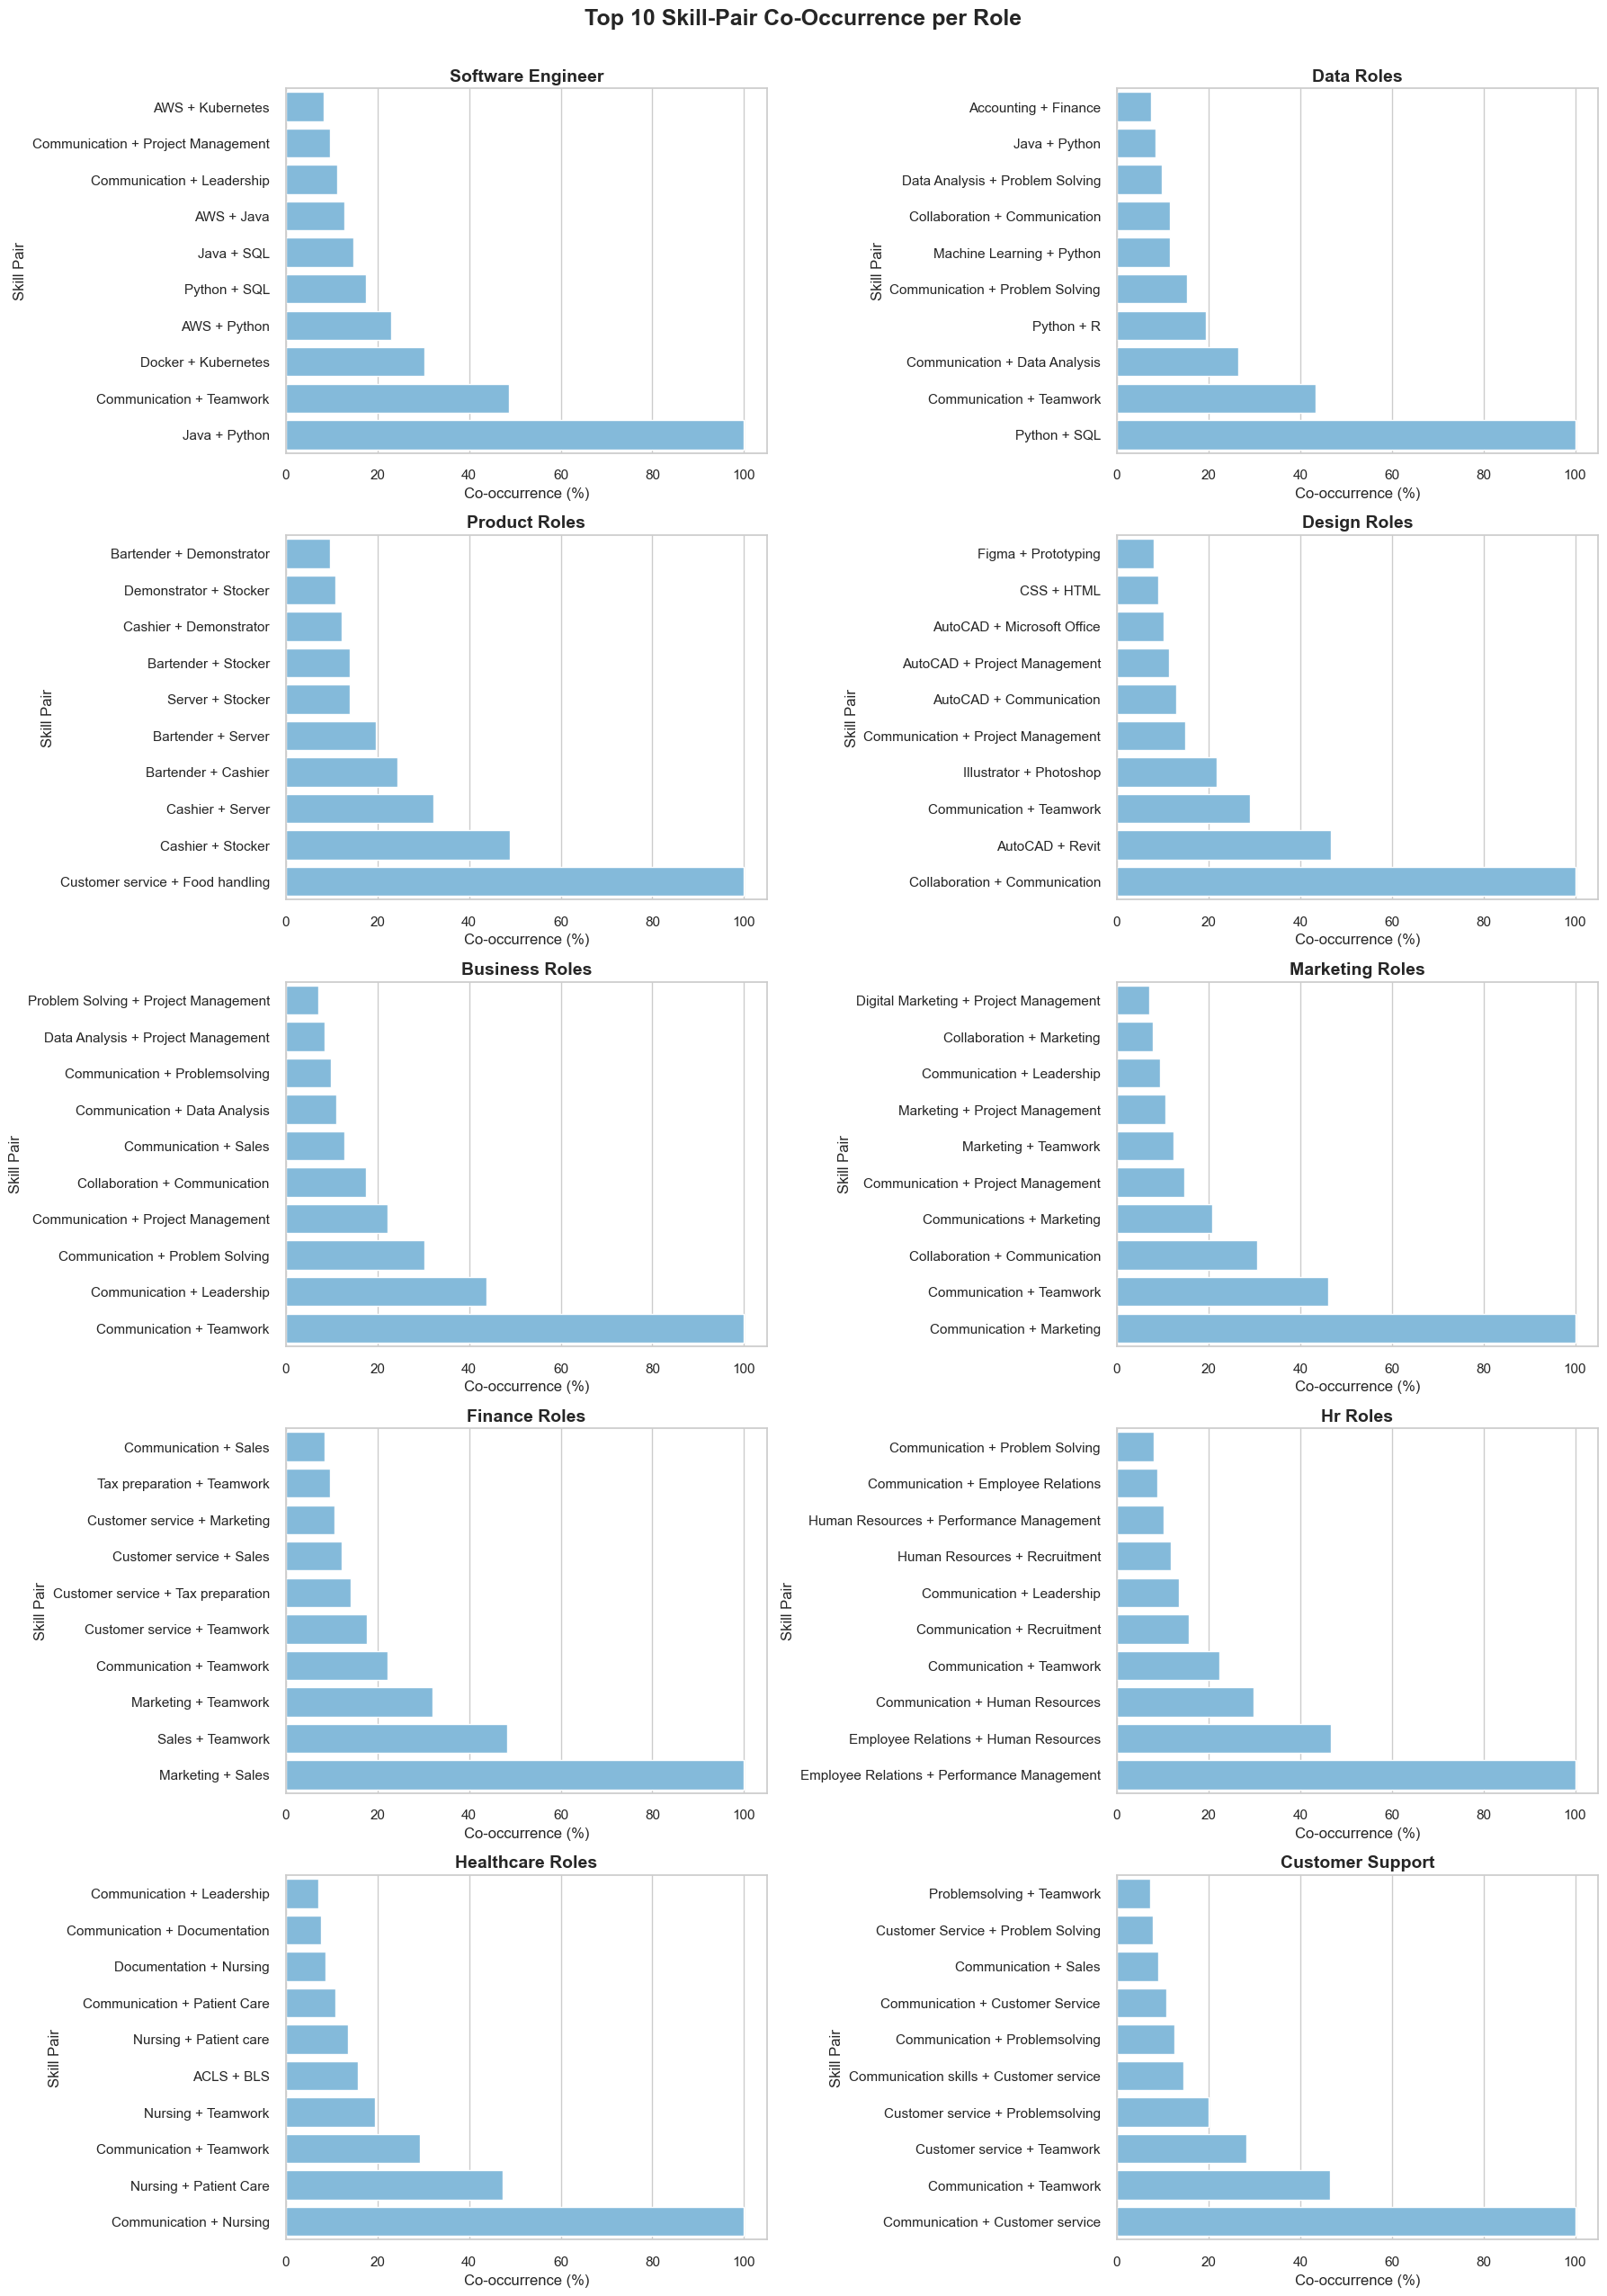

In [19]:
sns.set(style="whitegrid", rc={'font.size': 11})

top10_pairs_pd = top10_pairs.toPandas()
top10_pairs_pd["pct_display"] = top10_pairs_pd["pct"] * 100

roles_order = [
    "software_engineer",
    "data_roles",
    "product_roles",
    "design_roles",
    "business_roles",
    "marketing_roles",
    "finance_roles",
    "hr_roles",
    "healthcare_roles",
    "customer_support"
]

top10_pairs_pd = top10_pairs_pd[top10_pairs_pd["raw_role"].isin(roles_order)]
top10_pairs_pd["raw_role"] = pd.Categorical(top10_pairs_pd["raw_role"], categories=roles_order)

n_roles = len(roles_order)
n_cols = 2
n_rows = (n_roles + 1) // n_cols

plt.figure(figsize=(18, n_rows * 5))

for idx, role in enumerate(roles_order, start=1):
    
    df_role = top10_pairs_pd[top10_pairs_pd["raw_role"] == role].sort_values("pct_display")

    plt.subplot(n_rows, n_cols, idx)
    sns.barplot(
        data=df_role,
        x="pct_display",
        y="pair",
        color="#76BDE8"
    )
    plt.title(role.replace("_", " ").title(), fontsize=14, weight="bold")
    plt.xlabel("Co-occurrence (%)")
    plt.ylabel("Skill Pair")
    plt.tight_layout()

plt.suptitle("Top 10 Skill-Pair Co-Occurrence per Role", fontsize=18, weight="bold", y=1.02)
plt.show()


Above is the graph of Top 10 most frequent skill pairs co-occurence across each job role.

For example: in the designer roles: the skills like collaboration + communication along with tools like AutoCAD + Revit, Photoshop + illustrator are the key skills requirements for this job.

Classification of seniority based on skills

In [22]:
# Map seniority into 3 buckets
jobs_sen_bucket = (
    jobs_labeled_df
    .withColumn(
        "seniority_bucket",
        F.when(
            F.lower("seniority").rlike("intern|entry|junior|associate"),
            F.lit("Associate")
        ).when(
            F.lower("seniority").rlike("mid|mid-senior|intermediate"),
            F.lit("Mid-Senior")
        ).when(
            F.col("seniority").isNotNull(),
            F.lit("Senior")
        ).otherwise(F.lit("Unknown"))
    )
    .filter(F.col("seniority_bucket") != "Unknown")
)


roles_of_interest = [
    "software_engineer",
    "data_roles",
    "product_roles",
    "design_roles",
    "business_roles",
    "marketing_roles",
    "finance_roles",
    "hr_roles",
    "healthcare_roles",
    "customer_support"
]

df_roles = jobs_sen_bucket.filter(F.col("raw_role").isin(roles_of_interest))

exploded_skills = (
    df_roles
    .select("raw_role", "seniority_bucket", F.explode("skills_array").alias("skill"))
    .filter(F.col("skill").isNotNull())
)

skill_counts = (
    exploded_skills
    .groupBy("raw_role", "seniority_bucket", "skill")
    .agg(F.count("*").alias("count"))
)

w_role_bucket = Window.partitionBy("raw_role", "seniority_bucket")

skill_shares = (
    skill_counts
    .withColumn("total_in_bucket", F.sum("count").over(w_role_bucket))
    .withColumn("pct", F.col("count") / F.col("total_in_bucket"))
)


pivoted = (
    skill_shares
    .groupBy("raw_role", "skill")
    .pivot("seniority_bucket", ["Associate", "Mid-Senior", "Senior"])
    .agg(F.first("pct"))
    .fillna(0.0)
)


diff_df = (
    pivoted
    .withColumn("diff_pct", F.col("`Mid-Senior`") - F.col("Associate"))
    .withColumn(
        "skew",
        F.when(F.col("diff_pct") >= 0, F.lit("Mid-Senior skewed"))
         .otherwise(F.lit("Associate skewed"))
    )
)


w_abs = Window.partitionBy("raw_role").orderBy(F.desc(F.abs("diff_pct")))

top_diff_skills = (
    diff_df
    .withColumn("rank", F.row_number().over(w_abs))
    .filter(F.col("rank") <= 20)
)

top_diff_skills_pd = top_diff_skills.select(
    "raw_role", "skill", "diff_pct", "skew"
).toPandas()

top_diff_skills_pd["diff_pct_display"] = top_diff_skills_pd["diff_pct"] * 100




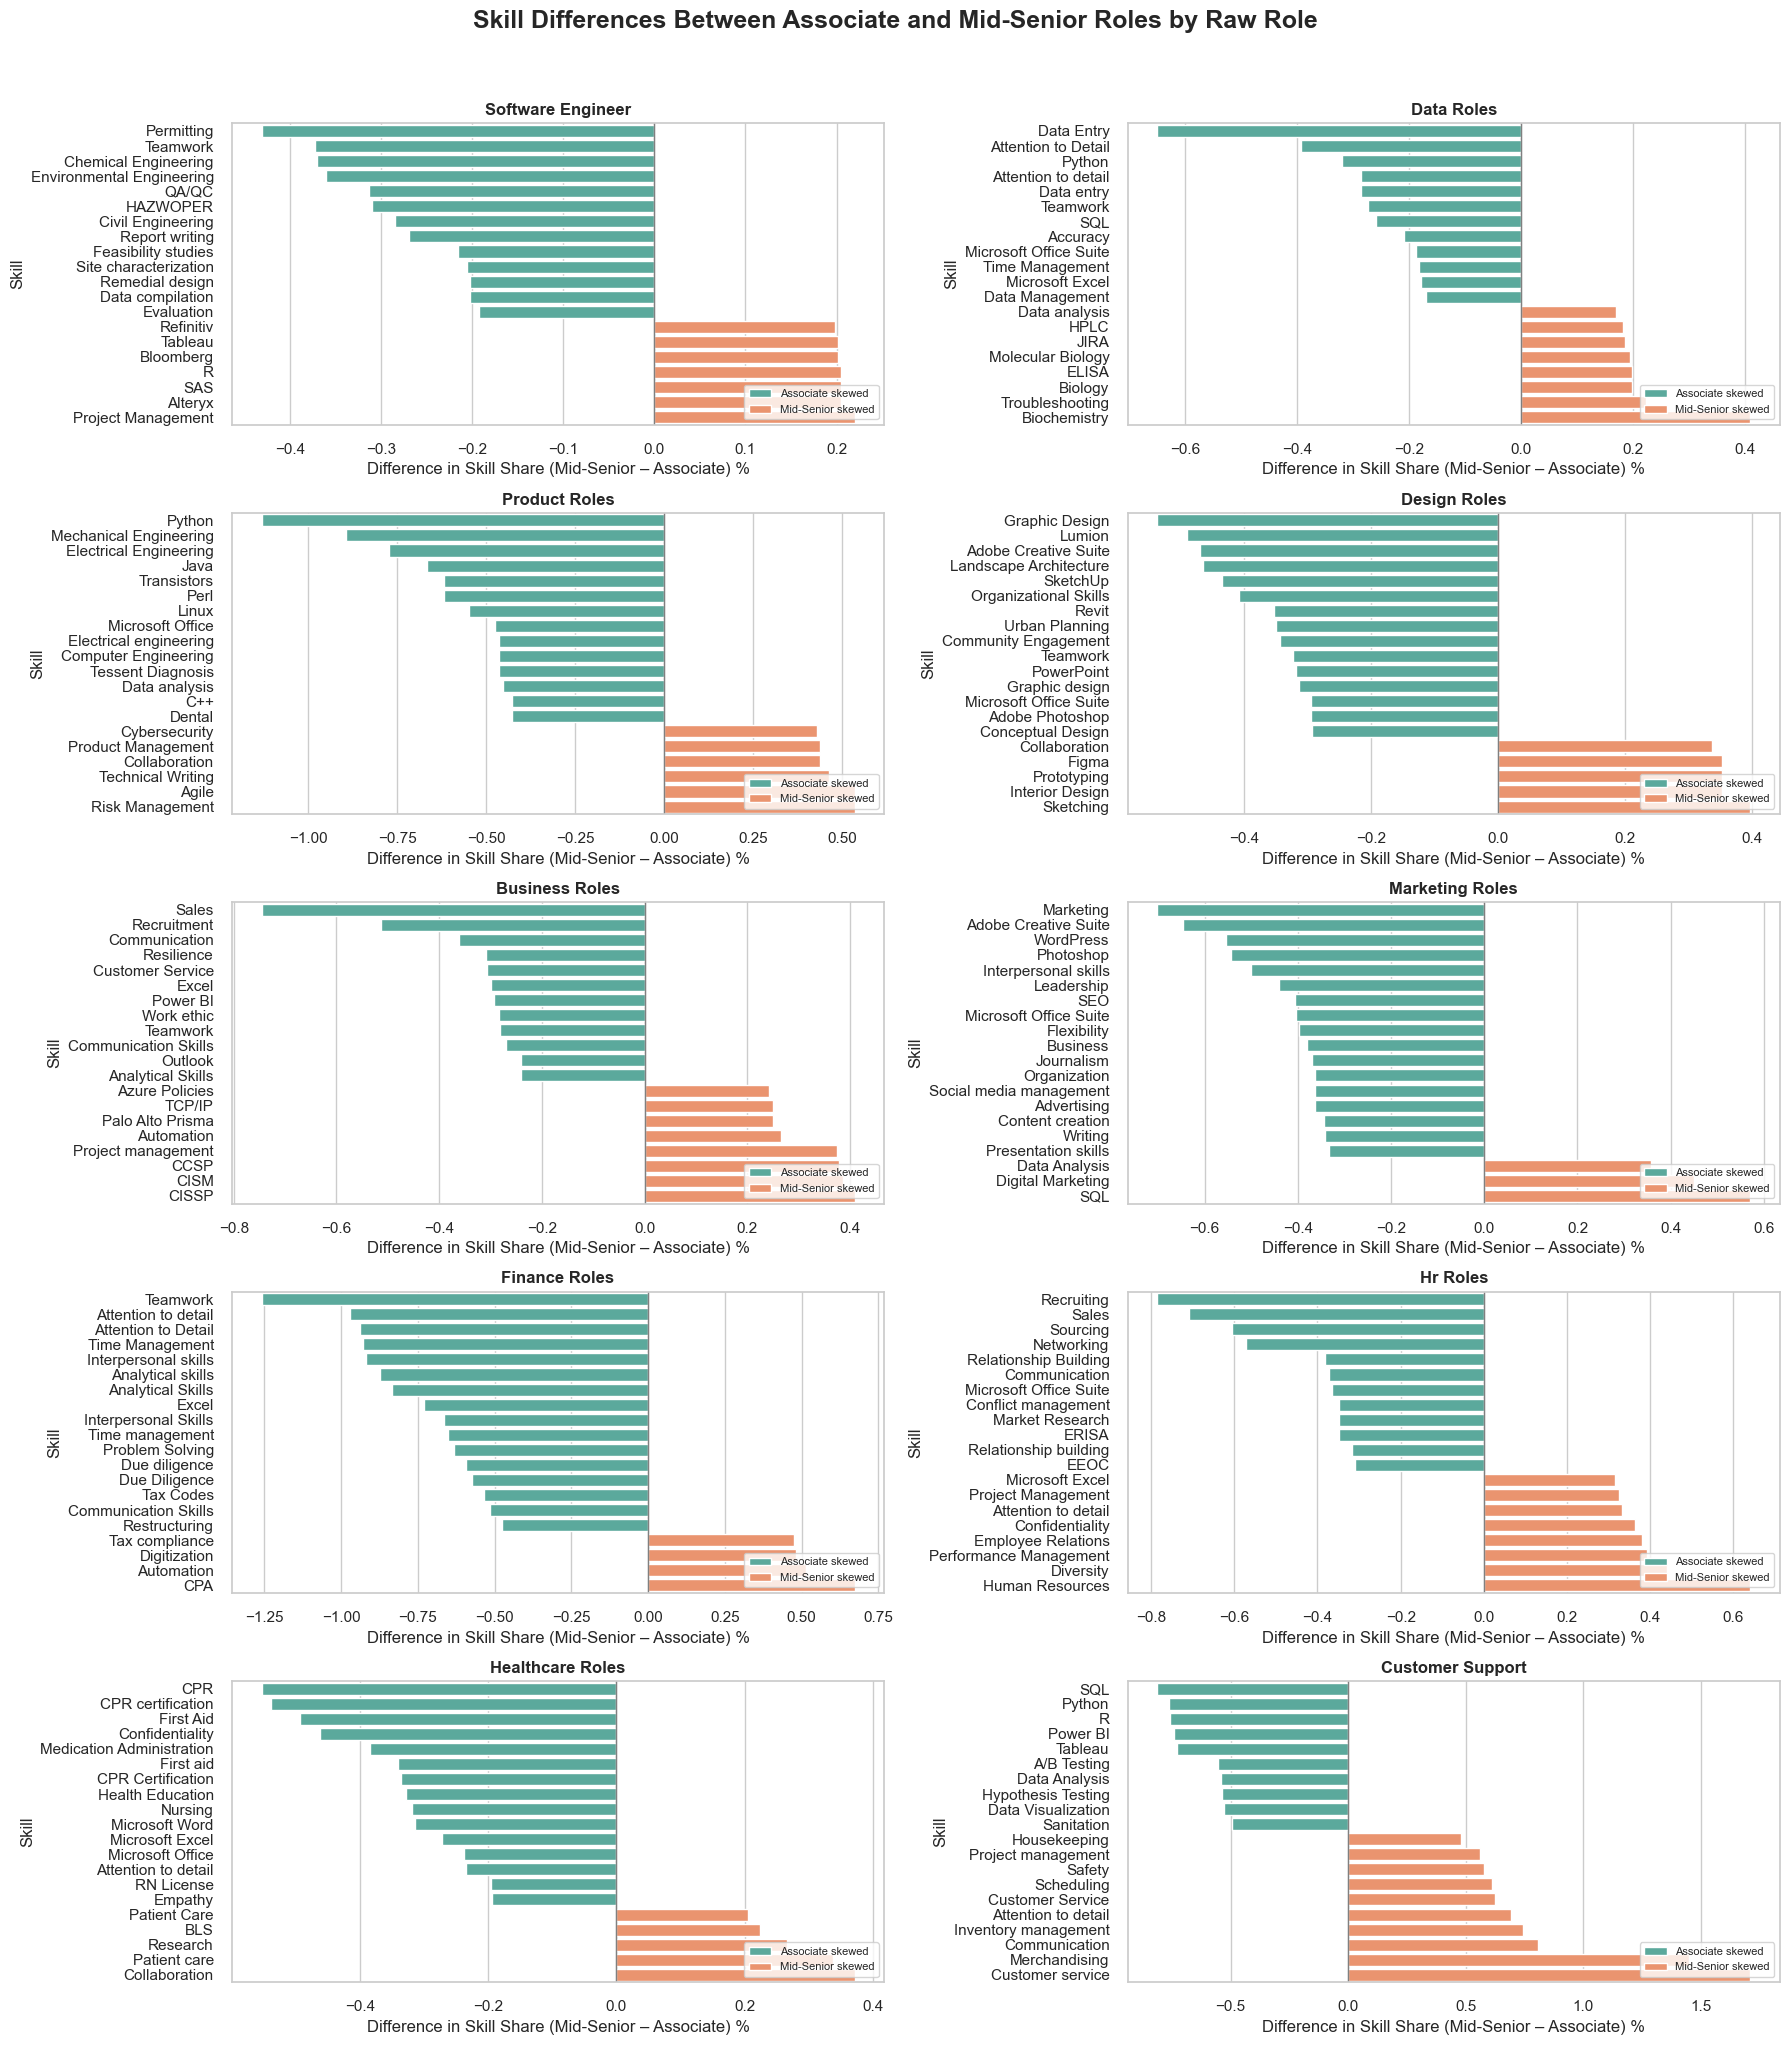

In [23]:
sns.set(style="whitegrid", rc={"font.size": 10})

roles_order = [
    "software_engineer",
    "data_roles",
    "product_roles",
    "design_roles",
    "business_roles",
    "marketing_roles",
    "finance_roles",
    "hr_roles",
    "healthcare_roles",
    "customer_support",
]

top_diff_skills_pd = top_diff_skills_pd[
    top_diff_skills_pd["raw_role"].isin(roles_order)
].copy()

top_diff_skills_pd["raw_role"] = pd.Categorical(
    top_diff_skills_pd["raw_role"],
    categories=roles_order,
    ordered=True
)

n_roles = len(roles_order)
n_cols = 2
n_rows = (n_roles + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4), sharex=False)
axes = axes.flatten()

palette = {
    "Mid-Senior skewed": "#FF8C5A",
    "Associate skewed": "#4EB6A5" 
}

for i, role in enumerate(roles_order):
    ax = axes[i]
    df_role = (
        top_diff_skills_pd[top_diff_skills_pd["raw_role"] == role]
        .sort_values("diff_pct_display")
    )

    sns.barplot(
        data=df_role,
        x="diff_pct_display",
        y="skill",
        hue="skew",
        dodge=False,
        palette=palette,
        ax=ax,
        orient="h"
    )

    ax.axvline(0, color="grey", linewidth=1)
    ax.set_title(role.replace("_", " ").title(), fontsize=12, weight="bold")
    ax.set_xlabel("Difference in Skill Share (Mid-Senior – Associate) %")
    ax.set_ylabel("Skill")

    ax.legend(loc="lower right", fontsize=8, frameon=True)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle(
    "Skill Differences Between Associate and Mid-Senior Roles by Raw Role",
    fontsize=18,
    weight="bold",
    y=1.02
)

plt.tight_layout()
plt.show()


In the above graph we are seeing probable skill difference between junior and senior roles across each job roles

Taking Business roles: a lot of associate level roles here require Sales, communication, customer service, work ethic, outlook as it is a bread and butter for anyone starting in a professional environment, but if we look at the senior roles the skill requirements are very domain specific and project management specific and also there is requirment of professional certifications

Job category distribution by search country

In [28]:
jobs_labeled_df.groupBy("search_country").count().orderBy(F.desc("count")).show(50, truncate=False)


+--------------+-------+
|search_country|count  |
+--------------+-------+
|United States |1149264|
|United Kingdom|113398 |
|Canada        |55963  |
|Australia     |29716  |
+--------------+-------+



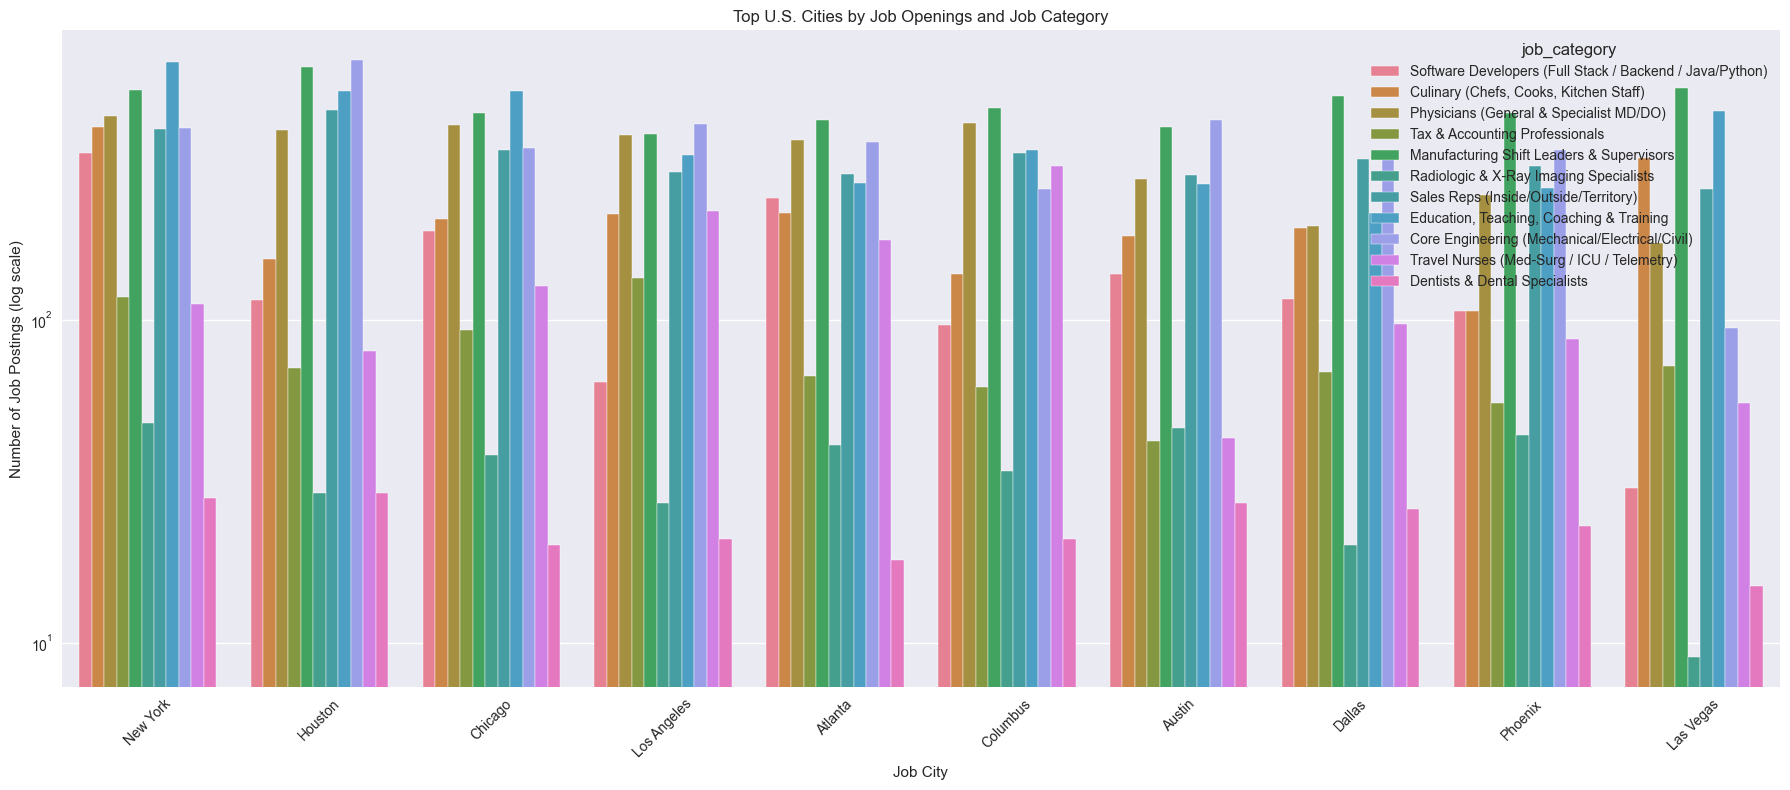

In [38]:
selected_categories = [
    "Software Developers (Full Stack / Backend / Java/Python)",
    "Core Engineering (Mechanical/Electrical/Civil)",
    "Education, Teaching, Coaching & Training",
    "Physicians (General & Specialist MD/DO)",
    "Radiologic & X-Ray Imaging Specialists",
    "Tax & Accounting Professionals",
    "Sales Reps (Inside/Outside/Territory)",
    "Travel Nurses (Med-Surg / ICU / Telemetry)",
    "Dentists & Dental Specialists",
    "Culinary (Chefs, Cooks, Kitchen Staff)",
    "Manufacturing Shift Leaders & Supervisors"
]

df_us = jobs_labeled_df.filter(
    (F.col("search_country") == "United States") &
    (F.col("job_category").isin(selected_categories))
)

city_counts = (
    df_us.groupBy("job_city", "job_category")
         .agg(F.count("*").alias("count"))
)

# Get top 10 cities overall
top_cities = (
    df_us.groupBy("job_city")
         .agg(F.count("*").alias("total"))
         .orderBy(F.desc("total"))
         .limit(10)
)

top_city_list = [r.job_city for r in top_cities.collect()]

city_counts_filtered = city_counts.filter(
    F.col("job_city").isin(top_city_list)
)

pdf = city_counts_filtered.toPandas()

pdf["job_city"] = pd.Categorical(pdf["job_city"], categories=top_city_list, ordered=True)

plt.figure(figsize=(18, 8))
sns.barplot(
    data=pdf,
    x="job_city",
    y="count",
    hue="job_category"
)
plt.yscale("log")
plt.title("Top U.S. Cities by Job Openings and Job Category")
plt.xlabel("Job City")
plt.ylabel("Number of Job Postings (log scale)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


New York has the highest number of Software Dev roles, Houston seems to be comparably equivalent to New York, Chicago is also catching up with New York for the software roles. Education, teaching, Coaching has been the pillar of the US and we can see it from the graph that there is no slowing down in this sector. Houston is a hotspot for Core Enqineering roles (Cicil/Mech/Electrical).

Overall these 10 cities in the US has the highest number of openings across all job categories

In [43]:
jobs_labeled_df.withColumn("vec_arr", vector_to_array("title_vec"))\
        .withColumn("vec_length", F.size("vec_arr"))\
        .select("vec_length")\
        .show(100)

+----------+
|vec_length|
+----------+
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|
|       100|

In [95]:
jobs_labeled_df.show(5, truncate=True)

+--------------------+--------------------+-----------+-------+---------------+--------------------+--------------------+--------------------+----------+--------+--------------------+----------+-----------+--------------+---------------------+--------------------+--------------------+----------+---------+--------------+---------+----------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------+--------------------+
|            job_link| last_processed_time|got_summary|got_ner|is_being_worked|             company|           job_title|     job_title_clean| job_level|job_type|        job_location|first_seen|search_city|search_country|search_position_clean|   job_summary_clean|        skills_array|  job_city|job_state|summary_length|seniority|        raw_role|          title_base|    title_normalized|        title_tokens|      title_filtered|           title_vec|cluster|        job_category|
+--------------------+------------

In [98]:
transfer_cols = [
    "job_link",
    "company",
    "job_title",
    "job_level",
    "job_type",
    "job_location",
    "first_seen",
    "search_position_clean",
    "skills_array",
    "job_city",
    "job_state",
    "seniority", 
    "raw_role",
    "cluster",
    "job_category"
]

transferable_df = jobs_labeled_df.select(transfer_cols)

In [100]:
transferable_df.repartition(1).write.mode("overwrite").parquet("jobs_transfer_temp")

In [101]:
import os

files = os.listdir("jobs_transfer_temp")
files

['.part-00000-617bb75e-69f4-440c-a80e-6812e13c6c65-c000.snappy.parquet.crc',
 '._SUCCESS.crc',
 'part-00000-617bb75e-69f4-440c-a80e-6812e13c6c65-c000.snappy.parquet',
 '_SUCCESS']

In [102]:
import shutil

src = "jobs_transfer_temp/part-00000-617bb75e-69f4-440c-a80e-6812e13c6c65-c000.snappy.parquet"
dst = "jobs_transfer_temp.parquet"

shutil.move(src, dst)

'jobs_transfer_temp.parquet'